## Import required libraries for dataset management, model building, training, and visualization.

In [11]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import random
import kagglehub
import shutil
import glob
import re
from tqdm import tqdm  # For progress tracking.

## Dataset Parsing

In [12]:
# Regular expressions for parsing Shakespeare text
CHARACTER_RE = re.compile(r'^  ([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Matches character lines
CONT_RE = re.compile(r'^    (.*)')  # Matches continuation lines
COE_CHARACTER_RE = re.compile(r'^([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Special regex for Comedy of Errors
COE_CONT_RE = re.compile(r'^(.*)')  # Continuation for Comedy of Errors


# Get current script directory
SCRIPT_DIR = os.getcwd()

# Download dataset
path = kagglehub.dataset_download("kewagbln/shakespeareonline")

# Debug: print downloaded files
print(f"Downloaded path: {path}")
print("Files in downloaded path:")
for file in glob.glob(os.path.join(path, "*")):
    print(f" - {file}")

# Set up paths relative to script location
DATA_PATH = os.path.join(SCRIPT_DIR, "shakespeare.txt")
OUTPUT_DIR = os.path.join(SCRIPT_DIR, "processed_data")

# Create directories if they don't exist
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Find and copy Shakespeare text file
shakespeare_file = None
for file in glob.glob(os.path.join(path, "*.txt")):
    shakespeare_file = file
    break

if shakespeare_file:
    shutil.copy2(shakespeare_file, DATA_PATH)
    print(f"Dataset saved to: {DATA_PATH}")
else:
    raise FileNotFoundError(f"Could not find Shakespeare text file in {path}")


Downloaded path: C:\Users\rosif\.cache\kagglehub\datasets\kewagbln\shakespeareonline\versions\1
Files in downloaded path:
 - C:\Users\rosif\.cache\kagglehub\datasets\kewagbln\shakespeareonline\versions\1\t8.shakespeare.txt
Dataset saved to: c:\Users\rosif\OneDrive\Desktop\Advance Machine Learning\Project2024\AdvanceML_project5\shakespeare.txt


## Dataset Preprocessing

In [13]:
def __txt_to_data(txt_dir, seq_length=80):
    """Parses text file in given directory into data for next-character model.

    Args:
        txt_dir: path to text file
        seq_length: length of strings in X
    """
    raw_text = ""
    with open(txt_dir,'r') as inf:
        raw_text = inf.read()
    raw_text = raw_text.replace('\n', ' ')
    raw_text = re.sub(r"   *", r' ', raw_text)
    dataX = []
    dataY = []
    for i in range(0, len(raw_text) - seq_length, 1):
        seq_in = raw_text[i:i + seq_length]
        seq_out = raw_text[i + seq_length]
        dataX.append(seq_in)
        dataY.append(seq_out)
    return dataX, dataY

def parse_data_in(data_dir, users_and_plays_path, raw=False):
    '''
    returns dictionary with keys: users, num_samples, user_data
    raw := bool representing whether to include raw text in all_data
    if raw is True, then user_data key
    removes users with no data
    '''
    with open(users_and_plays_path, 'r') as inf:
        users_and_plays = json.load(inf)
    files = os.listdir(data_dir)
    users = []
    hierarchies = []
    num_samples = []
    user_data = {}
    for f in files:
        user = f[:-4]
        passage = ''
        filename = os.path.join(data_dir, f)
        with open(filename, 'r') as inf:
            passage = inf.read()
        dataX, dataY = __txt_to_data(filename)
        if(len(dataX) > 0):
            users.append(user)
            if raw:
                user_data[user] = {'raw': passage}
            else:
                user_data[user] = {}
            user_data[user]['x'] = dataX
            user_data[user]['y'] = dataY
            hierarchies.append(users_and_plays[user])
            num_samples.append(len(dataY))
    all_data = {}
    all_data['users'] = users
    all_data['hierarchies'] = hierarchies
    all_data['num_samples'] = num_samples
    all_data['user_data'] = user_data
    return all_data

def parse_shakespeare(filepath, train_split=0.8):
    """
    Parses Shakespeare's text into training and testing datasets.
    """
    with open(filepath, "r") as file:
        raw_text = file.read()

    plays_data, _ = process_plays(raw_text)
    _, training_set, testing_set = split_train_test_data(plays_data, 1.0 - train_split)

    total_train = sum(len(lines) for lines in training_set.values())
    total_test = sum(len(lines) for lines in testing_set.values())
    print(f"Training examples: {total_train}")
    print(f"Testing examples: {total_test}")
    
    assert total_train > total_test, "Training set should be larger than test set"

    return training_set, testing_set

def process_plays(shakespeare_full):
    """
    Processes the Shakespeare text into individual plays and characters' dialogues.
    Handles special cases for "The Comedy of Errors".
    """
    plays = []
    slines = shakespeare_full.splitlines(True)[1:]  # Skip the first line (title/header)
    current_character = None
    comedy_of_errors = False

    for i, line in enumerate(slines):
        # Detect play titles and initialize character dictionary
        if "by William Shakespeare" in line:
            current_character = None
            characters = defaultdict(list)
            title = slines[i - 2].strip() if slines[i - 2].strip() else slines[i - 3].strip()
            comedy_of_errors = title == "THE COMEDY OF ERRORS"
            plays.append((title, characters))
            continue

        # Match character lines or continuation lines
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1).upper(), match.group(2)
            if not (comedy_of_errors and character.startswith("ACT ")):
                characters[character].append(snippet)
                current_character = character
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                characters[current_character].append(match.group(1))

    # Filter out plays with insufficient dialogue data
    return [play for play in plays if len(play[1]) > 1], []

def _match_character_regex(line, comedy_of_errors=False):
    """Matches character dialogues, with special handling for 'The Comedy of Errors'."""
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def _match_continuation_regex(line, comedy_of_errors=False):
    """Matches continuation lines of dialogues."""
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def extract_play_title(lines, index):
    """
    Extracts the title of the play from the lines of the text.
    """
    for i in range(index - 1, -1, -1):
        if lines[i].strip():
            return lines[i].strip()
    return "UNKNOWN"

def detect_character_line(line, comedy_of_errors):
    """
    Matches a line of character dialogue.
    """
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def detect_continuation_line(line, comedy_of_errors):
    """
    Matches a continuation line of dialogue.
    """
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def _split_into_plays(shakespeare_full):
    """Splits the full data by play."""
    # List of tuples (play_name, dict from character to list of lines)
    plays = []
    discarded_lines = []  # Track discarded lines.
    slines = shakespeare_full.splitlines(True)[1:]

    # skip contents, the sonnets, and all's well that ends well
    author_count = 0
    start_i = 0
    for i, l in enumerate(slines):
        if 'by William Shakespeare' in l:
            author_count += 1
        if author_count == 2:
            start_i = i - 5
            break
    slines = slines[start_i:]

    current_character = None
    comedy_of_errors = False
    for i, line in enumerate(slines):
        # This marks the end of the plays in the file.
        if i > 124195 - start_i:
            break
        # This is a pretty good heuristic for detecting the start of a new play:
        if 'by William Shakespeare' in line:
            current_character = None
            characters = collections.defaultdict(list)
            # The title will be 2, 3, 4, 5, 6, or 7 lines above "by William Shakespeare".
            if slines[i - 2].strip():
                title = slines[i - 2]
            elif slines[i - 3].strip():
                title = slines[i - 3]
            elif slines[i - 4].strip():
                title = slines[i - 4]
            elif slines[i - 5].strip():
                title = slines[i - 5]
            elif slines[i - 6].strip():
                title = slines[i - 6]
            else:
                title = slines[i - 7]
            title = title.strip()

            assert title, (
                'Parsing error on line %d. Expecting title 2 or 3 lines above.' %
                i)
            comedy_of_errors = (title == 'THE COMEDY OF ERRORS')
            # Degenerate plays are removed at the end of the method.
            plays.append((title, characters))
            continue
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1), match.group(2)
            # Some character names are written with multiple casings, e.g., SIR_Toby
            # and SIR_TOBY. To normalize the character names, we uppercase each name.
            # Note that this was not done in the original preprocessing and is a
            # recent fix.
            character = character.upper()
            if not (comedy_of_errors and character.startswith('ACT ')):
                characters[character].append(snippet)
                current_character = character
                continue
            else:
                current_character = None
                continue
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                if comedy_of_errors and match.group(1).startswith('<'):
                    current_character = None
                    continue
                else:
                    characters[current_character].append(match.group(1))
                    continue
        # Didn't consume the line.
        line = line.strip()
        if line and i > 2646:
            # Before 2646 are the sonnets, which we expect to discard.
            discarded_lines.append('%d:%s' % (i, line))
    # Remove degenerate "plays".
    return [play for play in plays if len(play[1]) > 1], discarded_lines


def _remove_nonalphanumerics(filename):
    return re.sub('\\W+', '_', filename)

def play_and_character(play, character):
    return _remove_nonalphanumerics((play + '_' + character).replace(' ', '_'))

def split_train_test_data(plays, test_fraction=0.2):
    """
    Splits the plays into training and testing datasets by character dialogues.
    """
    skipped_characters = 0
    all_train_examples = collections.defaultdict(list)
    all_test_examples = collections.defaultdict(list)

    def add_examples(example_dict, example_tuple_list):
        for play, character, sound_bite in example_tuple_list:
            example_dict[play_and_character(
                play, character)].append(sound_bite)

    users_and_plays = {}
    for play, characters in plays:
        curr_characters = list(characters.keys())
        for c in curr_characters:
            users_and_plays[play_and_character(play, c)] = play
        for character, sound_bites in characters.items():
            examples = [(play, character, sound_bite)
                        for sound_bite in sound_bites]
            if len(examples) <= 2:
                skipped_characters += 1
                # Skip characters with fewer than 2 lines since we need at least one
                # train and one test line.
                continue
            train_examples = examples
            if test_fraction > 0:
                num_test = max(int(len(examples) * test_fraction), 1)
                train_examples = examples[:-num_test]
                test_examples = examples[-num_test:]
                
                assert len(test_examples) == num_test
                assert len(train_examples) >= len(test_examples)

                add_examples(all_test_examples, test_examples)
                add_examples(all_train_examples, train_examples)

    return users_and_plays, all_train_examples, all_test_examples


def _write_data_by_character(examples, output_directory):
    """Writes a collection of data files by play & character."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    for character_name, sound_bites in examples.items():
        filename = os.path.join(output_directory, character_name + '.txt')
        with open(filename, 'w') as output:
            for sound_bite in sound_bites:
                output.write(sound_bite + '\n')


## Dataset Utilities

In [14]:
def letter_to_vec(c, n_vocab=90):
    """Converts a single character to a vector index based on the vocabulary size."""
    return ord(c) % n_vocab

def word_to_indices(word, n_vocab=90):
    """
    Converts a word or list of words into a list of indices.
    Each character is mapped to an index based on the vocabulary size.
    """
    if isinstance(word, list):  # If input is a list of words
        res = []
        for stringa in word:
            res.extend([ord(c) % n_vocab for c in stringa])  # Convert each word to indices
        return res
    else:  # If input is a single word
        return [ord(c) % n_vocab for c in word]

def process_x(raw_x_batch, seq_len, n_vocab):
    """
    Processes raw input data into padded sequences of indices.
    Ensures all sequences are of uniform length.
    """
    x_batch = [word_to_indices(word, n_vocab) for word in raw_x_batch]
    x_batch = [x[:seq_len] + [0] * (seq_len - len(x)) for x in x_batch]
    return torch.tensor(x_batch, dtype=torch.long)

def process_y(raw_y_batch, seq_len, n_vocab):
    """
    Processes raw target data into padded sequences of indices.
    Shifts the sequence by one character to the right.
    y[1:seq_len + 1] takes the input data, right shift of an
    element and uses the next element of the sequence to fill
    and at the end (with [0]) final padding (zeros) are (eventually)
    added to reach the desired sequence length.
    """
    y_batch = [word_to_indices(word, n_vocab) for word in raw_y_batch]
    y_batch = [y[1:seq_len + 1] + [0] * (seq_len - len(y[1:seq_len + 1])) for y in y_batch]  # Shifting and final padding
    return torch.tensor(y_batch, dtype=torch.long)

def create_batches(data, batch_size, seq_len, n_vocab):
    """
    Creates batches of input and target data from dialogues.
    Each batch contains sequences of uniform length.
    """
    x_batches = []
    y_batches = []
    dialogues = list(data.values())
    random.shuffle(dialogues)  # Shuffle to ensure randomness in batches

    batch = []
    for dialogue in dialogues:
        batch.append(dialogue)
        if len(batch) == batch_size:
            x_batch = process_x(batch, seq_len, n_vocab)
            y_batch = process_y(batch, seq_len, n_vocab)
            x_batches.append(x_batch)
            y_batches.append(y_batch)
            batch = []

    # Add the last batch if it's not full
    if batch:
        x_batch = process_x(batch, seq_len, n_vocab)
        y_batch = process_y(batch, seq_len, n_vocab)
        x_batches.append(x_batch)
        y_batches.append(y_batch)

    return x_batches, y_batches


## Save Results

In [15]:
def save_results_centralized(model, optimizer, subfolder, epoch, lr, wd, results):
            """Salva il risultato del modello e rimuove quello precedente."""
            subfolder_path = os.path.join(OUTPUT_DIR, subfolder)
            os.makedirs(subfolder_path, exist_ok=True)

            # File corrente e precedente
            filename = f"model_epoch_{epoch}_params_LR{lr}_WD{wd}.pth"
            filepath = os.path.join(subfolder_path, filename)
            filename_json = f"model_epoch_{epoch}_params_LR{lr}_WD{wd}.json"
            filepath_json = os.path.join(subfolder_path, filename_json)


            previous_filename = f"model_epoch_{epoch -1}_params_LR{lr}_WD{wd}.pth"
            previous_filepath = os.path.join(subfolder_path, previous_filename)
            previous_filename_json = f"model_epoch_{epoch -1}_params_LR{lr}_WD{wd}.json"
            previous_filepath_json = os.path.join(subfolder_path, previous_filename_json)

            # Rimuove il checkpoint precedente
            if epoch > 1 and os.path.exists(previous_filepath) and os.path.exists(previous_filepath_json):
                os.remove(previous_filepath)
                os.remove(previous_filepath_json)

            # Salva il nuovo checkpoint
            if optimizer is not None:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),  # Salvataggio dello stato dell'ottimizzatore
                    'epoch': epoch
                }, filepath)
            else:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'epoch': epoch
                }, filepath)

            
            with open(filepath_json, 'w') as json_file:
                json.dump(results, json_file, indent=4)


## Plot results

In [16]:
def plot_results_centralized(validation_losses, validation_accuracies, lr, wd):
    # Plot centralized validation performance
    plt.figure(figsize=(12,10))
    # Plot Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(validation_losses, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss Across Learning Rates and Weight Decays")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(validation_accuracies, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy Across Learning Rates and Weight Decays")
    plt.legend()

    # Plot Test Loss
    plt.subplot(2, 2, 3)
    plt.plot(validation_losses, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Test Loss Across Learning Rates and Weight Decays")
    plt.legend()


    # Plot Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(validation_accuracies, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Across Learning Rates and Weight Decays")
    plt.legend()

    plt.savefig(f"processed_data/Centralized_lr{lr}_wd{wd}/val_test_loss_accuracy.png")

    plt.tight_layout()

## Shakespeare Dataset

In [17]:
# Class to handle the Shakespeare dataset in a way suitable for PyTorch.
class ShakespeareDataset(Dataset):
    def __init__(self, text, clients=None, seq_length=80, n_vocab=90):
        """
        Initialize the dataset by loading and preprocessing the data.
        Args:
        - data_path: Path to the JSON file containing the dataset.
        - clients: List of client IDs to load data for (default: all clients).
        - seq_length: Sequence length for character-level data.
        """
        self.seq_length = seq_length  # Sequence length for the model
        self.n_vocab = n_vocab  # Vocabulary size

        # Create character mappings
        self.data = list(text.values())  # Convert the dictionary values to a list
            

    def __len__(self):
        """
        Return the number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve the input-target pair at the specified index.
        """
        diag = self.data[idx]
        x = process_x(diag, self.seq_length, self.n_vocab)
        y = process_y(diag, self.seq_length, self.n_vocab)
        return x[0], y[0]


## LSTM Model 

In [18]:
# Define the character-level LSTM model for Shakespeare data.
class CharLSTM(nn.Module):
    def __init__(self, n_vocab=90, embedding_dim=8, hidden_dim=256, seq_length=80, num_layers=2):
        """
        Initialize the LSTM model.
        Args:
        - n_vocab: Number of unique characters in the dataset.
        - embedding_dim: Size of the character embedding.
        - hidden_dim: Number of LSTM hidden units.
        - num_layers: Number of LSTM layers.
        - seq_length: Length of input sequences.
        """
        super(CharLSTM, self).__init__()
        self.seq_length = seq_length
        self.n_vocab = n_vocab
        self.embedding_size = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Character embedding layer: Maps indices to dense vectors.
        self.embedding = nn.Embedding(n_vocab, embedding_dim)  # Character embedding layer.
        
        # LSTM layers
        self.lstm_first = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM first layer
        self.lstm_second = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM second layer.
        
        # Fully connected layer: Maps LSTM output to vocabulary size.
        self.fc = nn.Linear(hidden_dim, n_vocab)  # Output layer (vocab_size outputs).

    def forward(self, x, hidden=None):
        """
        Forward pass of the model.
        Args:
        - x: Input batch (character indices).
        - hidden: Hidden state for LSTM (default: None, initialized internally).
        Returns:
        - Output logits and the updated hidden state.
        """
        # Embedding layer: Convert indices to embeddings.
        x = self.embedding(x)  
        # First LSTM
        output, hidden = self.lstm_first(x, hidden)  # Process through first LSTM layer.
        # Second LSTM
        output, hidden = self.lstm_second(x, hidden)  # Process through second LSTM layer.
        # Fully connected layer: Generate logits for each character.
        output = self.fc(output)

        # Note: Softmax is not applied here because CrossEntropyLoss in PyTorch
        # combines the softmax operation with the computation of the loss. 
        # Adding softmax here would be redundant and could introduce numerical instability.
        return output, hidden

    def hidden(self, batch_size):
        """
        Initializes hidden and cell states for the LSTM.
        Args:
        - batch_size: Number of sequences in the batch.
        Returns:
        - A tuple of zero-initialized hidden and cell states.
        """
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
            torch.zeros(self.num_layers, batch_size, self.hidden_dim))


## Centralized Training

In [19]:
# Define the centralized training pipeline.
def train_centralized(model, train_data, test_data, val_data, criterion, optimizer, scheduler, epochs, device, lr, wd):
    """
    Train the model on a centralized dataset.
    Args:
    - model: The LSTM model to train.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for test data.
    - criterion: Loss function.
    - optimizer: Optimizer (SGD).
    - scheduler: Learning rate scheduler.
    - epochs: Number of training epochs.
    - device: Device to train on (CPU or GPU).
    Returns:
    - Training losses and accuracies, along with test loss and accuracy.
    """
    model.to(device)  # Move model to the device (CPU/GPU).
    model.train()  # Set the model to training mode.
    epoch_train_losses = []  # Store training loss for each epoch.
    epoch_train_accuracies = []  # Store training accuracy for each epoch.
    epoch_validation_losses = []  # Store validation loss for each epoch.
    epoch_validation_accuracies = []  # Store validation accuracy for each epoch.
    epoch_test_losses = []  # Store test loss for each epoch.
    epoch_test_accuracies = []  # Store test accuracy for each epoch.

    subfolder = f"Centralized_lr{lr}_wd{wd}"

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        progress = tqdm(train_data, desc=f"Epoch {epoch + 1}/{epochs}")  # Track progress.

        for inputs, targets in progress:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Clear previous gradients.
            outputs, _ = model(inputs)  # Forward pass.
            outputs = outputs.view(-1, model.n_vocab)  # Reshape for loss computation.
            targets = targets.view(-1)  # Reshape for loss computation.
            loss = criterion(outputs, targets)  # Compute loss.
            loss.backward()  # Backpropagation.
            optimizer.step()  # Update weights.

            total_loss += loss.item()
            _, predictions = outputs.max(1)  # Get predictions.
            correct_predictions += (predictions == targets).sum().item()  # Count correct predictions.
            total_samples += targets.size(0)  # Update sample count.
            progress.set_postfix(loss=loss.item())  # Show current loss.

        train_accuracy = correct_predictions / total_samples  # Compute accuracy.
        avg_loss = total_loss / len(train_data)  # Compute average loss.
        epoch_train_losses.append(avg_loss)
        epoch_train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        scheduler.step()  # Update learning rate (scheduler).

        # Evaluate on the validation set.
        val_loss, val_accuracy = evaluate_model(model, val_data, criterion, device)
        epoch_validation_losses.append(val_loss)
        epoch_validation_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Evaluate on the test set.
        test_loss, test_accuracy = evaluate_model(model, test_data, criterion, device)
        epoch_test_losses.append(test_loss)
        epoch_test_accuracies.append(test_accuracy)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        results={
                'train_losses': epoch_train_losses,
                'train_accuracies': epoch_train_accuracies,
                'validation_losses': epoch_validation_losses,
                'validation_accuracies': epoch_validation_accuracies,
                'test_losses': epoch_test_losses,
                'test_accuracies': epoch_test_accuracies
                    }
        
        save_results_centralized(model, optimizer, subfolder, epoch, lr, wd, results)
        
    # Final evaluation on test set
    test_loss, test_accuracy = evaluate_model(model, test_data, criterion, device)
    print(f"Final -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return epoch_train_losses, epoch_train_accuracies, epoch_validation_losses, epoch_validation_accuracies, epoch_test_losses, epoch_test_accuracies


# Evaluate model performance on a dataset.
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate the model on a given dataset.
    Args:
    - model: Trained model.
    - data_loader: DataLoader for the evaluation dataset.
    - criterion: Loss function.
    - device: Device to evaluate on (CPU/GPU).
    Returns:
    - Average loss and accuracy.
    """
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Initialize hidden state
            state = model.hidden(inputs.size(0)) 
            state = (state[0].to(device), state[1].to(device)) 
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, model.n_vocab)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)  # Compute loss.
            total_loss += loss.item()
            _, predictions = outputs.max(1)
            correct_predictions += (predictions == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(data_loader)  # Compute average loss.
    accuracy = (correct_predictions / total_samples ) * 100  # Compute accuracy.
    return avg_loss, accuracy


## Main

Training examples: 85924
Testing examples: 20794
Starting centralized training...
Learning Rate = 0.1 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s, loss=2.11]


Epoch 1, Loss: 3.1694, Accuracy: 0.5143
Validation Loss: 2.0566, Validation Accuracy: 55.9013
Test Loss: 2.2204, Test Accuracy: 55.1783


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, loss=1.72]


Epoch 2, Loss: 1.9140, Accuracy: 0.5898
Validation Loss: 1.7143, Validation Accuracy: 62.0976
Test Loss: 1.8589, Test Accuracy: 61.8331


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, loss=1.68]


Epoch 3, Loss: 1.6385, Accuracy: 0.6172
Validation Loss: 1.4984, Validation Accuracy: 62.0601
Test Loss: 1.6207, Test Accuracy: 58.8875


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s, loss=1.4] 


Epoch 4, Loss: 1.4949, Accuracy: 0.6204
Validation Loss: 1.4256, Validation Accuracy: 62.3444
Test Loss: 1.5642, Test Accuracy: 59.2408


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  5.83it/s, loss=1.42]


Epoch 5, Loss: 1.4464, Accuracy: 0.6182
Validation Loss: 1.3948, Validation Accuracy: 63.1170
Test Loss: 1.5496, Test Accuracy: 60.0183


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, loss=1.29]


Epoch 6, Loss: 1.4195, Accuracy: 0.6249
Validation Loss: 1.3771, Validation Accuracy: 62.9775
Test Loss: 1.5354, Test Accuracy: 59.8207


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s, loss=1.52]


Epoch 7, Loss: 1.4118, Accuracy: 0.6259
Validation Loss: 1.3646, Validation Accuracy: 63.3745
Test Loss: 1.5336, Test Accuracy: 60.2567


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s, loss=1.43]


Epoch 8, Loss: 1.3992, Accuracy: 0.6281
Validation Loss: 1.3554, Validation Accuracy: 63.5944
Test Loss: 1.5342, Test Accuracy: 60.3243


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s, loss=1.49]


Epoch 9, Loss: 1.3929, Accuracy: 0.6295
Validation Loss: 1.3477, Validation Accuracy: 63.5569
Test Loss: 1.5297, Test Accuracy: 60.2620


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  7.41it/s, loss=1.52]


Epoch 10, Loss: 1.3874, Accuracy: 0.6300
Validation Loss: 1.3412, Validation Accuracy: 63.6642
Test Loss: 1.5309, Test Accuracy: 60.3973


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, loss=1.36]


Epoch 11, Loss: 1.3769, Accuracy: 0.6303
Validation Loss: 1.3362, Validation Accuracy: 63.7232
Test Loss: 1.5295, Test Accuracy: 60.4682


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  5.88it/s, loss=1.49]


Epoch 12, Loss: 1.3761, Accuracy: 0.6315
Validation Loss: 1.3317, Validation Accuracy: 63.9485
Test Loss: 1.5278, Test Accuracy: 60.7378


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, loss=1.39]


Epoch 13, Loss: 1.3695, Accuracy: 0.6330
Validation Loss: 1.3283, Validation Accuracy: 64.1041
Test Loss: 1.5267, Test Accuracy: 60.8623


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  5.51it/s, loss=1.51]


Epoch 14, Loss: 1.3700, Accuracy: 0.6347
Validation Loss: 1.3255, Validation Accuracy: 64.2436
Test Loss: 1.5259, Test Accuracy: 60.9472


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s, loss=1.17]


Epoch 15, Loss: 1.3574, Accuracy: 0.6349
Validation Loss: 1.3235, Validation Accuracy: 64.2918
Test Loss: 1.5246, Test Accuracy: 60.9719


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s, loss=1.32]


Epoch 16, Loss: 1.3604, Accuracy: 0.6355
Validation Loss: 1.3220, Validation Accuracy: 64.3562
Test Loss: 1.5245, Test Accuracy: 61.0256


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, loss=1.17]


Epoch 17, Loss: 1.3544, Accuracy: 0.6356
Validation Loss: 1.3210, Validation Accuracy: 64.3455
Test Loss: 1.5238, Test Accuracy: 61.0105


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s, loss=1.33]


Epoch 18, Loss: 1.3585, Accuracy: 0.6356
Validation Loss: 1.3204, Validation Accuracy: 64.3509
Test Loss: 1.5235, Test Accuracy: 61.0159


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, loss=1.38]


Epoch 19, Loss: 1.3598, Accuracy: 0.6356
Validation Loss: 1.3202, Validation Accuracy: 64.3616
Test Loss: 1.5235, Test Accuracy: 61.0266


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, loss=1.22]


Epoch 20, Loss: 1.3546, Accuracy: 0.6357
Validation Loss: 1.3201, Validation Accuracy: 64.3670
Test Loss: 1.5234, Test Accuracy: 61.0266
Final -> Test Loss: 1.5234, Test Accuracy: 61.0266
Update best result -> Val Accuracy: 64.3670, Val Loss: 1.3201, Test Accuracy: 61.0266, Test Loss: 1.5234
Learning Rate = 0.1 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  5.88it/s, loss=2.47]


Epoch 1, Loss: 3.3762, Accuracy: 0.5152
Validation Loss: 2.4626, Validation Accuracy: 55.8476
Test Loss: 2.6748, Test Accuracy: 52.5043


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, loss=1.78]


Epoch 2, Loss: 2.0927, Accuracy: 0.5612
Validation Loss: 1.7941, Validation Accuracy: 59.8712
Test Loss: 1.9173, Test Accuracy: 59.3825


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, loss=1.52]


Epoch 3, Loss: 1.6941, Accuracy: 0.6109
Validation Loss: 1.5406, Validation Accuracy: 61.9474
Test Loss: 1.6448, Test Accuracy: 61.5700


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  5.99it/s, loss=1.41]


Epoch 4, Loss: 1.5315, Accuracy: 0.6064
Validation Loss: 1.4583, Validation Accuracy: 62.0923
Test Loss: 1.5695, Test Accuracy: 61.7880


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.64it/s, loss=1.34]


Epoch 5, Loss: 1.4742, Accuracy: 0.6175
Validation Loss: 1.4284, Validation Accuracy: 62.1298
Test Loss: 1.5480, Test Accuracy: 61.7955


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.24it/s, loss=1.3] 


Epoch 6, Loss: 1.4506, Accuracy: 0.6178
Validation Loss: 1.4130, Validation Accuracy: 62.1513
Test Loss: 1.5321, Test Accuracy: 61.8460


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s, loss=1.44]


Epoch 7, Loss: 1.4429, Accuracy: 0.6181
Validation Loss: 1.4040, Validation Accuracy: 62.1781
Test Loss: 1.5224, Test Accuracy: 61.8954


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, loss=1.33]


Epoch 8, Loss: 1.4323, Accuracy: 0.6186
Validation Loss: 1.3974, Validation Accuracy: 62.2479
Test Loss: 1.5188, Test Accuracy: 61.9523


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, loss=1.28]


Epoch 9, Loss: 1.4249, Accuracy: 0.6191
Validation Loss: 1.3924, Validation Accuracy: 62.2961
Test Loss: 1.5159, Test Accuracy: 62.0006


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.24it/s, loss=1.48]


Epoch 10, Loss: 1.4263, Accuracy: 0.6194
Validation Loss: 1.3880, Validation Accuracy: 62.3659
Test Loss: 1.5150, Test Accuracy: 62.0468


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s, loss=1.51]


Epoch 11, Loss: 1.4233, Accuracy: 0.6200
Validation Loss: 1.3842, Validation Accuracy: 62.3820
Test Loss: 1.5127, Test Accuracy: 62.0522


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s, loss=1.41]


Epoch 12, Loss: 1.4169, Accuracy: 0.6202
Validation Loss: 1.3809, Validation Accuracy: 62.3927
Test Loss: 1.5124, Test Accuracy: 62.0844


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, loss=1.33]


Epoch 13, Loss: 1.4114, Accuracy: 0.6204
Validation Loss: 1.3782, Validation Accuracy: 62.4249
Test Loss: 1.5124, Test Accuracy: 61.9169


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s, loss=1.37]


Epoch 14, Loss: 1.4103, Accuracy: 0.6193
Validation Loss: 1.3761, Validation Accuracy: 62.3873
Test Loss: 1.5115, Test Accuracy: 59.5168


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  5.45it/s, loss=1.36]


Epoch 15, Loss: 1.4084, Accuracy: 0.6186
Validation Loss: 1.3744, Validation Accuracy: 62.3712
Test Loss: 1.5118, Test Accuracy: 59.2075


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s, loss=1.43]


Epoch 16, Loss: 1.4090, Accuracy: 0.6187
Validation Loss: 1.3732, Validation Accuracy: 62.3766
Test Loss: 1.5113, Test Accuracy: 59.1892


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, loss=1.48]


Epoch 17, Loss: 1.4095, Accuracy: 0.6187
Validation Loss: 1.3725, Validation Accuracy: 62.4142
Test Loss: 1.5111, Test Accuracy: 59.2032


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  5.49it/s, loss=1.44]


Epoch 18, Loss: 1.4078, Accuracy: 0.6189
Validation Loss: 1.3720, Validation Accuracy: 62.4142
Test Loss: 1.5113, Test Accuracy: 59.2053


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, loss=1.45]


Epoch 19, Loss: 1.4078, Accuracy: 0.6189
Validation Loss: 1.3718, Validation Accuracy: 62.4142
Test Loss: 1.5113, Test Accuracy: 59.2064


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, loss=1.28]


Epoch 20, Loss: 1.4025, Accuracy: 0.6189
Validation Loss: 1.3717, Validation Accuracy: 62.4142
Test Loss: 1.5113, Test Accuracy: 59.2064
Final -> Test Loss: 1.5113, Test Accuracy: 59.2064
Learning Rate = 0.1 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  8.04it/s, loss=1.9] 


Epoch 1, Loss: 2.8602, Accuracy: 0.5229
Validation Loss: 1.9999, Validation Accuracy: 58.9592
Test Loss: 2.1537, Test Accuracy: 58.7189


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, loss=1.87]


Epoch 2, Loss: 1.8629, Accuracy: 0.6075
Validation Loss: 1.6551, Validation Accuracy: 62.1191
Test Loss: 1.7460, Test Accuracy: 61.8406


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, loss=1.55]


Epoch 3, Loss: 1.5945, Accuracy: 0.6165
Validation Loss: 1.4863, Validation Accuracy: 61.0837
Test Loss: 1.6124, Test Accuracy: 57.6579


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  8.18it/s, loss=1.41]


Epoch 4, Loss: 1.4810, Accuracy: 0.6135
Validation Loss: 1.4221, Validation Accuracy: 61.8670
Test Loss: 1.5411, Test Accuracy: 61.6012


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, loss=1.63]


Epoch 5, Loss: 1.4459, Accuracy: 0.6149
Validation Loss: 1.3928, Validation Accuracy: 62.0869
Test Loss: 1.5318, Test Accuracy: 58.9036


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s, loss=1.49]


Epoch 6, Loss: 1.4210, Accuracy: 0.6164
Validation Loss: 1.3772, Validation Accuracy: 62.3391
Test Loss: 1.5244, Test Accuracy: 59.0668


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, loss=1.37]


Epoch 7, Loss: 1.4043, Accuracy: 0.6182
Validation Loss: 1.3658, Validation Accuracy: 62.4785
Test Loss: 1.5170, Test Accuracy: 59.1710


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, loss=1.45]


Epoch 8, Loss: 1.3970, Accuracy: 0.6205
Validation Loss: 1.3572, Validation Accuracy: 62.6717
Test Loss: 1.5172, Test Accuracy: 59.3095


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=1.41]


Epoch 9, Loss: 1.3877, Accuracy: 0.6229
Validation Loss: 1.3497, Validation Accuracy: 62.8863
Test Loss: 1.5136, Test Accuracy: 59.4437


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s, loss=1.38]


Epoch 10, Loss: 1.3802, Accuracy: 0.6247
Validation Loss: 1.3433, Validation Accuracy: 63.0794
Test Loss: 1.5134, Test Accuracy: 59.5844


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, loss=1.39]


Epoch 11, Loss: 1.3745, Accuracy: 0.6270
Validation Loss: 1.3378, Validation Accuracy: 63.1706
Test Loss: 1.5109, Test Accuracy: 59.6284


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s, loss=1.38]


Epoch 12, Loss: 1.3693, Accuracy: 0.6279
Validation Loss: 1.3334, Validation Accuracy: 63.2028
Test Loss: 1.5097, Test Accuracy: 59.6907


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, loss=1.41]


Epoch 13, Loss: 1.3662, Accuracy: 0.6277
Validation Loss: 1.3297, Validation Accuracy: 63.3047
Test Loss: 1.5075, Test Accuracy: 59.7917


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s, loss=1.44]


Epoch 14, Loss: 1.3635, Accuracy: 0.6288
Validation Loss: 1.3268, Validation Accuracy: 63.3476
Test Loss: 1.5052, Test Accuracy: 59.8314


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s, loss=1.44]


Epoch 15, Loss: 1.3611, Accuracy: 0.6297
Validation Loss: 1.3246, Validation Accuracy: 63.3906
Test Loss: 1.5040, Test Accuracy: 59.8679


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  7.38it/s, loss=1.38]


Epoch 16, Loss: 1.3571, Accuracy: 0.6295
Validation Loss: 1.3230, Validation Accuracy: 63.4335
Test Loss: 1.5031, Test Accuracy: 59.8787


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, loss=1.36]


Epoch 17, Loss: 1.3552, Accuracy: 0.6295
Validation Loss: 1.3219, Validation Accuracy: 63.4281
Test Loss: 1.5026, Test Accuracy: 59.8819


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s, loss=1.36]


Epoch 18, Loss: 1.3543, Accuracy: 0.6297
Validation Loss: 1.3213, Validation Accuracy: 63.4549
Test Loss: 1.5021, Test Accuracy: 59.9012


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, loss=1.33]


Epoch 19, Loss: 1.3530, Accuracy: 0.6298
Validation Loss: 1.3211, Validation Accuracy: 63.4496
Test Loss: 1.5019, Test Accuracy: 59.9055


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, loss=1.48]


Epoch 20, Loss: 1.3573, Accuracy: 0.6299
Validation Loss: 1.3210, Validation Accuracy: 63.4496
Test Loss: 1.5019, Test Accuracy: 59.9076
Final -> Test Loss: 1.5019, Test Accuracy: 59.9076
Learning Rate = 0.01 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s, loss=3.91]


Epoch 1, Loss: 4.2991, Accuracy: 0.3298
Validation Loss: 3.8228, Validation Accuracy: 55.8476
Test Loss: 3.8712, Test Accuracy: 52.5043


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, loss=2.44]


Epoch 2, Loss: 3.0604, Accuracy: 0.5540
Validation Loss: 2.1481, Validation Accuracy: 55.8476
Test Loss: 2.3312, Test Accuracy: 52.5043


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, loss=2.18]


Epoch 3, Loss: 2.1642, Accuracy: 0.5540
Validation Loss: 2.0907, Validation Accuracy: 55.8476
Test Loss: 2.2934, Test Accuracy: 52.5032


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, loss=2.04]


Epoch 4, Loss: 2.0752, Accuracy: 0.5539
Validation Loss: 1.9793, Validation Accuracy: 55.8637
Test Loss: 2.1539, Test Accuracy: 52.5032


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, loss=1.85]


Epoch 5, Loss: 2.0016, Accuracy: 0.5539
Validation Loss: 1.9458, Validation Accuracy: 55.9120
Test Loss: 2.1104, Test Accuracy: 52.5644


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, loss=2.19]


Epoch 6, Loss: 1.9809, Accuracy: 0.5549
Validation Loss: 1.9157, Validation Accuracy: 56.0300
Test Loss: 2.0744, Test Accuracy: 52.7513


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  7.57it/s, loss=2.04]


Epoch 7, Loss: 1.9476, Accuracy: 0.5563
Validation Loss: 1.8880, Validation Accuracy: 56.1964
Test Loss: 2.0411, Test Accuracy: 52.9553


Epoch 8/20: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s, loss=2.04]


Epoch 8, Loss: 1.9213, Accuracy: 0.5586
Validation Loss: 1.8624, Validation Accuracy: 56.5504
Test Loss: 2.0097, Test Accuracy: 53.3698


Epoch 9/20: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s, loss=1.92]


Epoch 9, Loss: 1.8930, Accuracy: 0.5626
Validation Loss: 1.8386, Validation Accuracy: 57.0118
Test Loss: 1.9803, Test Accuracy: 53.8864


Epoch 10/20: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s, loss=1.82]


Epoch 10, Loss: 1.8670, Accuracy: 0.5673
Validation Loss: 1.8162, Validation Accuracy: 57.5590
Test Loss: 1.9524, Test Accuracy: 54.5157


Epoch 11/20: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s, loss=1.84]


Epoch 11, Loss: 1.8465, Accuracy: 0.5738
Validation Loss: 1.7963, Validation Accuracy: 58.2672
Test Loss: 1.9275, Test Accuracy: 55.2534


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s, loss=1.93]


Epoch 12, Loss: 1.8304, Accuracy: 0.5810
Validation Loss: 1.7787, Validation Accuracy: 59.0129
Test Loss: 1.9057, Test Accuracy: 55.8988


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, loss=1.75]


Epoch 13, Loss: 1.8087, Accuracy: 0.5872
Validation Loss: 1.7641, Validation Accuracy: 59.5976
Test Loss: 1.8875, Test Accuracy: 56.4046


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s, loss=1.72]


Epoch 14, Loss: 1.7946, Accuracy: 0.5919
Validation Loss: 1.7523, Validation Accuracy: 59.9785
Test Loss: 1.8729, Test Accuracy: 56.9427


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s, loss=1.73]


Epoch 15, Loss: 1.7843, Accuracy: 0.5952
Validation Loss: 1.7435, Validation Accuracy: 60.2092
Test Loss: 1.8621, Test Accuracy: 57.1757


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  5.48it/s, loss=1.61]


Epoch 16, Loss: 1.7730, Accuracy: 0.5972
Validation Loss: 1.7371, Validation Accuracy: 60.3165
Test Loss: 1.8543, Test Accuracy: 57.3088


Epoch 17/20: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s, loss=1.82]


Epoch 17, Loss: 1.7740, Accuracy: 0.5982
Validation Loss: 1.7330, Validation Accuracy: 60.4345
Test Loss: 1.8492, Test Accuracy: 57.4066


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.91it/s, loss=1.88]


Epoch 18, Loss: 1.7726, Accuracy: 0.5990
Validation Loss: 1.7306, Validation Accuracy: 60.5311
Test Loss: 1.8463, Test Accuracy: 57.4570


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  7.34it/s, loss=1.93]


Epoch 19, Loss: 1.7723, Accuracy: 0.5994
Validation Loss: 1.7296, Validation Accuracy: 60.5526
Test Loss: 1.8450, Test Accuracy: 57.4871


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, loss=1.5] 


Epoch 20, Loss: 1.7587, Accuracy: 0.5995
Validation Loss: 1.7293, Validation Accuracy: 60.5472
Test Loss: 1.8447, Test Accuracy: 57.4936
Final -> Test Loss: 1.8447, Test Accuracy: 57.4936
Learning Rate = 0.01 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=3.93]


Epoch 1, Loss: 4.2886, Accuracy: 0.3681
Validation Loss: 3.8558, Validation Accuracy: 55.8476
Test Loss: 3.9016, Test Accuracy: 52.5043


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, loss=2.34]


Epoch 2, Loss: 3.1496, Accuracy: 0.5540
Validation Loss: 2.2124, Validation Accuracy: 55.8476
Test Loss: 2.3807, Test Accuracy: 52.5054


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s, loss=1.94]


Epoch 3, Loss: 2.1156, Accuracy: 0.5540
Validation Loss: 2.0553, Validation Accuracy: 55.8476
Test Loss: 2.2337, Test Accuracy: 52.5043


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, loss=1.81]


Epoch 4, Loss: 2.0573, Accuracy: 0.5541
Validation Loss: 1.9784, Validation Accuracy: 55.9120
Test Loss: 2.1542, Test Accuracy: 52.5773


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, loss=1.86]


Epoch 5, Loss: 1.9939, Accuracy: 0.5556
Validation Loss: 1.9363, Validation Accuracy: 56.2017
Test Loss: 2.1099, Test Accuracy: 55.4865


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s, loss=2.05]


Epoch 6, Loss: 1.9674, Accuracy: 0.5601
Validation Loss: 1.9100, Validation Accuracy: 56.5236
Test Loss: 2.0807, Test Accuracy: 56.1018


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, loss=1.79]


Epoch 7, Loss: 1.9351, Accuracy: 0.5631
Validation Loss: 1.8856, Validation Accuracy: 56.8884
Test Loss: 2.0528, Test Accuracy: 56.6591


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, loss=1.87]


Epoch 8, Loss: 1.9139, Accuracy: 0.5672
Validation Loss: 1.8624, Validation Accuracy: 57.2854
Test Loss: 2.0258, Test Accuracy: 57.0640


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s, loss=1.84]


Epoch 9, Loss: 1.8904, Accuracy: 0.5714
Validation Loss: 1.8404, Validation Accuracy: 57.7414
Test Loss: 2.0002, Test Accuracy: 57.5762


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  7.93it/s, loss=2.03]


Epoch 10, Loss: 1.8750, Accuracy: 0.5763
Validation Loss: 1.8198, Validation Accuracy: 58.2833
Test Loss: 1.9759, Test Accuracy: 58.1143


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, loss=1.75]


Epoch 11, Loss: 1.8470, Accuracy: 0.5811
Validation Loss: 1.8007, Validation Accuracy: 58.6052
Test Loss: 1.9534, Test Accuracy: 58.5567


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s, loss=2]   


Epoch 12, Loss: 1.8367, Accuracy: 0.5846
Validation Loss: 1.7839, Validation Accuracy: 58.8627
Test Loss: 1.9335, Test Accuracy: 59.0142


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, loss=1.73]


Epoch 13, Loss: 1.8132, Accuracy: 0.5887
Validation Loss: 1.7697, Validation Accuracy: 59.1953
Test Loss: 1.9165, Test Accuracy: 59.3578


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  8.05it/s, loss=1.87]


Epoch 14, Loss: 1.8045, Accuracy: 0.5919
Validation Loss: 1.7581, Validation Accuracy: 59.4903
Test Loss: 1.9026, Test Accuracy: 59.6145


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, loss=1.81]


Epoch 15, Loss: 1.7923, Accuracy: 0.5947
Validation Loss: 1.7492, Validation Accuracy: 59.7693
Test Loss: 1.8920, Test Accuracy: 59.8271


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  7.71it/s, loss=1.77]


Epoch 16, Loss: 1.7835, Accuracy: 0.5966
Validation Loss: 1.7428, Validation Accuracy: 59.8766
Test Loss: 1.8843, Test Accuracy: 59.9936


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.39it/s, loss=1.93]


Epoch 17, Loss: 1.7830, Accuracy: 0.5976
Validation Loss: 1.7386, Validation Accuracy: 60.0429
Test Loss: 1.8793, Test Accuracy: 60.1063


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, loss=1.64]


Epoch 18, Loss: 1.7708, Accuracy: 0.5988
Validation Loss: 1.7362, Validation Accuracy: 60.1073
Test Loss: 1.8764, Test Accuracy: 60.1514


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s, loss=1.81]


Epoch 19, Loss: 1.7743, Accuracy: 0.5994
Validation Loss: 1.7352, Validation Accuracy: 60.1502
Test Loss: 1.8751, Test Accuracy: 60.1740


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, loss=1.92]


Epoch 20, Loss: 1.7768, Accuracy: 0.5995
Validation Loss: 1.7349, Validation Accuracy: 60.1448
Test Loss: 1.8748, Test Accuracy: 60.1793
Final -> Test Loss: 1.8748, Test Accuracy: 60.1793
Learning Rate = 0.01 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, loss=3.64]


Epoch 1, Loss: 4.1361, Accuracy: 0.5531
Validation Loss: 3.4904, Validation Accuracy: 55.8476
Test Loss: 3.5636, Test Accuracy: 52.5043


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.31it/s, loss=2.01]


Epoch 2, Loss: 2.6412, Accuracy: 0.5540
Validation Loss: 2.0312, Validation Accuracy: 55.8530
Test Loss: 2.2153, Test Accuracy: 52.4903


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, loss=1.92]


Epoch 3, Loss: 2.0565, Accuracy: 0.5540
Validation Loss: 2.0057, Validation Accuracy: 55.9174
Test Loss: 2.1913, Test Accuracy: 52.5623


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, loss=2.15]


Epoch 4, Loss: 2.0337, Accuracy: 0.5546
Validation Loss: 1.9643, Validation Accuracy: 56.0891
Test Loss: 2.1417, Test Accuracy: 52.7309


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s, loss=2.18]


Epoch 5, Loss: 1.9970, Accuracy: 0.5572
Validation Loss: 1.9334, Validation Accuracy: 56.3036
Test Loss: 2.1045, Test Accuracy: 53.0530


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, loss=2.27]


Epoch 6, Loss: 1.9726, Accuracy: 0.5612
Validation Loss: 1.9093, Validation Accuracy: 56.8133
Test Loss: 2.0756, Test Accuracy: 53.4665


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, loss=1.97]


Epoch 7, Loss: 1.9408, Accuracy: 0.5655
Validation Loss: 1.8868, Validation Accuracy: 57.4088
Test Loss: 2.0489, Test Accuracy: 54.0260


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s, loss=2]   


Epoch 8, Loss: 1.9201, Accuracy: 0.5713
Validation Loss: 1.8656, Validation Accuracy: 57.8004
Test Loss: 2.0236, Test Accuracy: 57.1145


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, loss=1.88]


Epoch 9, Loss: 1.8958, Accuracy: 0.5761
Validation Loss: 1.8453, Validation Accuracy: 58.3101
Test Loss: 1.9995, Test Accuracy: 57.7180


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, loss=2.08]


Epoch 10, Loss: 1.8823, Accuracy: 0.5814
Validation Loss: 1.8265, Validation Accuracy: 58.8734
Test Loss: 1.9769, Test Accuracy: 58.2141


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  7.78it/s, loss=1.99]


Epoch 11, Loss: 1.8617, Accuracy: 0.5864
Validation Loss: 1.8094, Validation Accuracy: 59.2006
Test Loss: 1.9565, Test Accuracy: 58.6491


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  8.32it/s, loss=1.73]


Epoch 12, Loss: 1.8379, Accuracy: 0.5907
Validation Loss: 1.7941, Validation Accuracy: 59.6620
Test Loss: 1.9381, Test Accuracy: 59.0754


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s, loss=1.88]


Epoch 13, Loss: 1.8284, Accuracy: 0.5948
Validation Loss: 1.7814, Validation Accuracy: 60.0215
Test Loss: 1.9228, Test Accuracy: 59.4545


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, loss=2.02]


Epoch 14, Loss: 1.8209, Accuracy: 0.5980
Validation Loss: 1.7709, Validation Accuracy: 60.3487
Test Loss: 1.9102, Test Accuracy: 59.8207


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, loss=1.66]


Epoch 15, Loss: 1.8007, Accuracy: 0.6008
Validation Loss: 1.7629, Validation Accuracy: 60.5794
Test Loss: 1.9005, Test Accuracy: 60.0473


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  7.44it/s, loss=1.92]


Epoch 16, Loss: 1.8018, Accuracy: 0.6027
Validation Loss: 1.7572, Validation Accuracy: 60.7296
Test Loss: 1.8936, Test Accuracy: 60.2051


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, loss=1.75]


Epoch 17, Loss: 1.7919, Accuracy: 0.6038
Validation Loss: 1.7533, Validation Accuracy: 60.8315
Test Loss: 1.8890, Test Accuracy: 60.2975


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.56it/s, loss=1.87]


Epoch 18, Loss: 1.7923, Accuracy: 0.6046
Validation Loss: 1.7512, Validation Accuracy: 60.8745
Test Loss: 1.8864, Test Accuracy: 60.3522


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, loss=1.84]


Epoch 19, Loss: 1.7899, Accuracy: 0.6050
Validation Loss: 1.7502, Validation Accuracy: 60.9067
Test Loss: 1.8852, Test Accuracy: 60.3705


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s, loss=1.6] 


Epoch 20, Loss: 1.7818, Accuracy: 0.6051
Validation Loss: 1.7499, Validation Accuracy: 60.9120
Test Loss: 1.8849, Test Accuracy: 60.3802
Final -> Test Loss: 1.8849, Test Accuracy: 60.3802
Learning Rate = 0.001 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, loss=4.48]


Epoch 1, Loss: 4.5210, Accuracy: 0.0077
Validation Loss: 4.4693, Validation Accuracy: 0.9335
Test Loss: 4.4695, Test Accuracy: 1.0180


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s, loss=4.33]


Epoch 2, Loss: 4.4074, Accuracy: 0.2898
Validation Loss: 4.3303, Validation Accuracy: 55.5848
Test Loss: 4.3404, Test Accuracy: 52.3196


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  7.50it/s, loss=4.17]


Epoch 3, Loss: 4.2621, Accuracy: 0.5525
Validation Loss: 4.1758, Validation Accuracy: 55.8155
Test Loss: 4.1971, Test Accuracy: 52.4764


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  7.52it/s, loss=4.03]


Epoch 4, Loss: 4.1058, Accuracy: 0.5538
Validation Loss: 4.0081, Validation Accuracy: 55.8476
Test Loss: 4.0417, Test Accuracy: 52.5032


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, loss=3.85]


Epoch 5, Loss: 3.9337, Accuracy: 0.5539
Validation Loss: 3.8247, Validation Accuracy: 55.8530
Test Loss: 3.8717, Test Accuracy: 52.5043


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  8.14it/s, loss=3.65]


Epoch 6, Loss: 3.7446, Accuracy: 0.5540
Validation Loss: 3.6224, Validation Accuracy: 55.8637
Test Loss: 3.6844, Test Accuracy: 52.5118


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, loss=3.52]


Epoch 7, Loss: 3.5408, Accuracy: 0.5543
Validation Loss: 3.4004, Validation Accuracy: 55.8959
Test Loss: 3.4790, Test Accuracy: 52.5473


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, loss=3.23]


Epoch 8, Loss: 3.3155, Accuracy: 0.5545
Validation Loss: 3.1710, Validation Accuracy: 55.9227
Test Loss: 3.2669, Test Accuracy: 52.5655


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  7.37it/s, loss=2.98]


Epoch 9, Loss: 3.0899, Accuracy: 0.5548
Validation Loss: 2.9450, Validation Accuracy: 55.9442
Test Loss: 3.0580, Test Accuracy: 52.5977


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s, loss=2.8] 


Epoch 10, Loss: 2.8780, Accuracy: 0.5552
Validation Loss: 2.7434, Validation Accuracy: 55.9710
Test Loss: 2.8719, Test Accuracy: 52.6192


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, loss=2.83]


Epoch 11, Loss: 2.7029, Accuracy: 0.5556
Validation Loss: 2.5820, Validation Accuracy: 55.9871
Test Loss: 2.7230, Test Accuracy: 52.6439


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  7.33it/s, loss=2.5] 


Epoch 12, Loss: 2.5579, Accuracy: 0.5560
Validation Loss: 2.4649, Validation Accuracy: 56.0193
Test Loss: 2.6151, Test Accuracy: 52.6579


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  7.35it/s, loss=2.45]


Epoch 13, Loss: 2.4614, Accuracy: 0.5561
Validation Loss: 2.3850, Validation Accuracy: 56.0193
Test Loss: 2.5415, Test Accuracy: 52.6654


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s, loss=2.36]


Epoch 14, Loss: 2.3950, Accuracy: 0.5562
Validation Loss: 2.3329, Validation Accuracy: 56.0247
Test Loss: 2.4935, Test Accuracy: 52.6718


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  7.96it/s, loss=2.31]


Epoch 15, Loss: 2.3521, Accuracy: 0.5563
Validation Loss: 2.2996, Validation Accuracy: 56.0354
Test Loss: 2.4629, Test Accuracy: 52.6729


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, loss=2.48]


Epoch 16, Loss: 2.3313, Accuracy: 0.5564
Validation Loss: 2.2786, Validation Accuracy: 56.0515
Test Loss: 2.4436, Test Accuracy: 52.6772


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, loss=2.29]


Epoch 17, Loss: 2.3091, Accuracy: 0.5564
Validation Loss: 2.2663, Validation Accuracy: 56.0569
Test Loss: 2.4323, Test Accuracy: 52.6965


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.89it/s, loss=2.21]


Epoch 18, Loss: 2.2976, Accuracy: 0.5565
Validation Loss: 2.2596, Validation Accuracy: 56.0569
Test Loss: 2.4262, Test Accuracy: 52.6965


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=2.04]


Epoch 19, Loss: 2.2876, Accuracy: 0.5565
Validation Loss: 2.2567, Validation Accuracy: 56.0569
Test Loss: 2.4235, Test Accuracy: 52.6954


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.17it/s, loss=2.25]


Epoch 20, Loss: 2.2921, Accuracy: 0.5565
Validation Loss: 2.2560, Validation Accuracy: 56.0569
Test Loss: 2.4228, Test Accuracy: 52.6954
Final -> Test Loss: 2.4228, Test Accuracy: 52.6954
Learning Rate = 0.001 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, loss=4.45]


Epoch 1, Loss: 4.4914, Accuracy: 0.0513
Validation Loss: 4.4517, Validation Accuracy: 53.8734
Test Loss: 4.4579, Test Accuracy: 50.4929


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.23it/s, loss=4.36]


Epoch 2, Loss: 4.4069, Accuracy: 0.5513
Validation Loss: 4.3470, Validation Accuracy: 55.8637
Test Loss: 4.3606, Test Accuracy: 52.5226


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s, loss=4.2] 


Epoch 3, Loss: 4.2964, Accuracy: 0.5541
Validation Loss: 4.2321, Validation Accuracy: 55.8476
Test Loss: 4.2538, Test Accuracy: 52.5043


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  7.78it/s, loss=4.1] 


Epoch 4, Loss: 4.1809, Accuracy: 0.5540
Validation Loss: 4.1097, Validation Accuracy: 55.8476
Test Loss: 4.1401, Test Accuracy: 52.5043


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s, loss=3.99]


Epoch 5, Loss: 4.0577, Accuracy: 0.5540
Validation Loss: 3.9799, Validation Accuracy: 55.8476
Test Loss: 4.0198, Test Accuracy: 52.5043


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s, loss=3.89]


Epoch 6, Loss: 3.9276, Accuracy: 0.5540
Validation Loss: 3.8407, Validation Accuracy: 55.8476
Test Loss: 3.8908, Test Accuracy: 52.5043


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s, loss=3.71]


Epoch 7, Loss: 3.7856, Accuracy: 0.5540
Validation Loss: 3.6923, Validation Accuracy: 55.8476
Test Loss: 3.7534, Test Accuracy: 52.5043


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.62it/s, loss=3.49]


Epoch 8, Loss: 3.6339, Accuracy: 0.5540
Validation Loss: 3.5362, Validation Accuracy: 55.8476
Test Loss: 3.6090, Test Accuracy: 52.5043


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s, loss=3.47]


Epoch 9, Loss: 3.4822, Accuracy: 0.5540
Validation Loss: 3.3752, Validation Accuracy: 55.8476
Test Loss: 3.4602, Test Accuracy: 52.5043


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  8.26it/s, loss=3.26]


Epoch 10, Loss: 3.3230, Accuracy: 0.5540
Validation Loss: 3.2171, Validation Accuracy: 55.8476
Test Loss: 3.3142, Test Accuracy: 52.5043


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, loss=3.13]


Epoch 11, Loss: 3.1725, Accuracy: 0.5540
Validation Loss: 3.0679, Validation Accuracy: 55.8476
Test Loss: 3.1766, Test Accuracy: 52.5043


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.54it/s, loss=3.14]


Epoch 12, Loss: 3.0379, Accuracy: 0.5540
Validation Loss: 2.9363, Validation Accuracy: 55.8476
Test Loss: 3.0552, Test Accuracy: 52.5043


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  7.55it/s, loss=2.81]


Epoch 13, Loss: 2.9117, Accuracy: 0.5540
Validation Loss: 2.8279, Validation Accuracy: 55.8476
Test Loss: 2.9552, Test Accuracy: 52.5043


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, loss=2.76]


Epoch 14, Loss: 2.8170, Accuracy: 0.5540
Validation Loss: 2.7432, Validation Accuracy: 55.8476
Test Loss: 2.8772, Test Accuracy: 52.5043


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, loss=2.79]


Epoch 15, Loss: 2.7471, Accuracy: 0.5540
Validation Loss: 2.6813, Validation Accuracy: 55.8476
Test Loss: 2.8203, Test Accuracy: 52.5043


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, loss=2.79]


Epoch 16, Loss: 2.6968, Accuracy: 0.5540
Validation Loss: 2.6392, Validation Accuracy: 55.8476
Test Loss: 2.7815, Test Accuracy: 52.5043


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s, loss=2.7] 


Epoch 17, Loss: 2.6607, Accuracy: 0.5540
Validation Loss: 2.6127, Validation Accuracy: 55.8476
Test Loss: 2.7570, Test Accuracy: 52.5043


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.90it/s, loss=2.71]


Epoch 18, Loss: 2.6409, Accuracy: 0.5540
Validation Loss: 2.5979, Validation Accuracy: 55.8476
Test Loss: 2.7435, Test Accuracy: 52.5043


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, loss=2.62]


Epoch 19, Loss: 2.6276, Accuracy: 0.5540
Validation Loss: 2.5914, Validation Accuracy: 55.8476
Test Loss: 2.7375, Test Accuracy: 52.5043


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, loss=2.58]


Epoch 20, Loss: 2.6221, Accuracy: 0.5540
Validation Loss: 2.5898, Validation Accuracy: 55.8476
Test Loss: 2.7360, Test Accuracy: 52.5043
Final -> Test Loss: 2.7360, Test Accuracy: 52.5043
Learning Rate = 0.001 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  7.57it/s, loss=4.45]


Epoch 1, Loss: 4.4727, Accuracy: 0.0179
Validation Loss: 4.4360, Validation Accuracy: 53.8090
Test Loss: 4.4408, Test Accuracy: 50.4134


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s, loss=4.33]


Epoch 2, Loss: 4.3949, Accuracy: 0.5486
Validation Loss: 4.3430, Validation Accuracy: 55.7725
Test Loss: 4.3545, Test Accuracy: 52.4624


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  8.05it/s, loss=4.26]


Epoch 3, Loss: 4.2991, Accuracy: 0.5539
Validation Loss: 4.2390, Validation Accuracy: 55.8476
Test Loss: 4.2580, Test Accuracy: 52.5032


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s, loss=4.14]


Epoch 4, Loss: 4.1942, Accuracy: 0.5540
Validation Loss: 4.1315, Validation Accuracy: 55.8476
Test Loss: 4.1583, Test Accuracy: 52.5043


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s, loss=4.05]


Epoch 5, Loss: 4.0871, Accuracy: 0.5540
Validation Loss: 4.0184, Validation Accuracy: 55.8476
Test Loss: 4.0536, Test Accuracy: 52.5043


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=3.87]


Epoch 6, Loss: 3.9717, Accuracy: 0.5540
Validation Loss: 3.9004, Validation Accuracy: 55.8476
Test Loss: 3.9444, Test Accuracy: 52.5043


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, loss=3.81]


Epoch 7, Loss: 3.8552, Accuracy: 0.5540
Validation Loss: 3.7770, Validation Accuracy: 55.8476
Test Loss: 3.8302, Test Accuracy: 52.5043


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.74it/s, loss=3.65]


Epoch 8, Loss: 3.7308, Accuracy: 0.5540
Validation Loss: 3.6503, Validation Accuracy: 55.8476
Test Loss: 3.7130, Test Accuracy: 52.5043


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, loss=3.57]


Epoch 9, Loss: 3.6071, Accuracy: 0.5540
Validation Loss: 3.5211, Validation Accuracy: 55.8476
Test Loss: 3.5937, Test Accuracy: 52.5043


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s, loss=3.42]


Epoch 10, Loss: 3.4798, Accuracy: 0.5540
Validation Loss: 3.3953, Validation Accuracy: 55.8476
Test Loss: 3.4776, Test Accuracy: 52.5043


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, loss=3.26]


Epoch 11, Loss: 3.3578, Accuracy: 0.5540
Validation Loss: 3.2752, Validation Accuracy: 55.8530
Test Loss: 3.3668, Test Accuracy: 52.5054


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, loss=3.21]


Epoch 12, Loss: 3.2462, Accuracy: 0.5540
Validation Loss: 3.1671, Validation Accuracy: 55.8530
Test Loss: 3.2671, Test Accuracy: 52.5043


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s, loss=3.14]


Epoch 13, Loss: 3.1475, Accuracy: 0.5540
Validation Loss: 3.0735, Validation Accuracy: 55.8530
Test Loss: 3.1807, Test Accuracy: 52.5043


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=3.06]


Epoch 14, Loss: 3.0631, Accuracy: 0.5540
Validation Loss: 2.9974, Validation Accuracy: 55.8530
Test Loss: 3.1105, Test Accuracy: 52.5043


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, loss=2.98]


Epoch 15, Loss: 2.9956, Accuracy: 0.5540
Validation Loss: 2.9388, Validation Accuracy: 55.8530
Test Loss: 3.0565, Test Accuracy: 52.5043


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, loss=2.91]


Epoch 16, Loss: 2.9448, Accuracy: 0.5540
Validation Loss: 2.8970, Validation Accuracy: 55.8530
Test Loss: 3.0180, Test Accuracy: 52.5032


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, loss=2.84]


Epoch 17, Loss: 2.9090, Accuracy: 0.5540
Validation Loss: 2.8698, Validation Accuracy: 55.8530
Test Loss: 2.9929, Test Accuracy: 52.5032


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, loss=2.86]


Epoch 18, Loss: 2.8889, Accuracy: 0.5540
Validation Loss: 2.8543, Validation Accuracy: 55.8530
Test Loss: 2.9786, Test Accuracy: 52.5021


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, loss=2.86]


Epoch 19, Loss: 2.8778, Accuracy: 0.5540
Validation Loss: 2.8473, Validation Accuracy: 55.8530
Test Loss: 2.9722, Test Accuracy: 52.5021


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s, loss=2.87]


Epoch 20, Loss: 2.8736, Accuracy: 0.5540
Validation Loss: 2.8456, Validation Accuracy: 55.8530
Test Loss: 2.9705, Test Accuracy: 52.5021
Final -> Test Loss: 2.9705, Test Accuracy: 52.5021
Learning Rate = 0.0001 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s, loss=4.45]


Epoch 1, Loss: 4.4576, Accuracy: 0.0006
Validation Loss: 4.4529, Validation Accuracy: 0.0536
Test Loss: 4.4577, Test Accuracy: 0.0548


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.19it/s, loss=4.44]


Epoch 2, Loss: 4.4487, Accuracy: 0.0562
Validation Loss: 4.4422, Validation Accuracy: 51.7006
Test Loss: 4.4477, Test Accuracy: 48.1304


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s, loss=4.43]


Epoch 3, Loss: 4.4377, Accuracy: 0.5367
Validation Loss: 4.4308, Validation Accuracy: 54.8712
Test Loss: 4.4371, Test Accuracy: 51.6387


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, loss=4.42]


Epoch 4, Loss: 4.4266, Accuracy: 0.5456
Validation Loss: 4.4195, Validation Accuracy: 55.1073
Test Loss: 4.4266, Test Accuracy: 51.9448


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=4.42]


Epoch 5, Loss: 4.4162, Accuracy: 0.5475
Validation Loss: 4.4086, Validation Accuracy: 55.3326
Test Loss: 4.4166, Test Accuracy: 52.1370


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, loss=4.4] 


Epoch 6, Loss: 4.4055, Accuracy: 0.5497
Validation Loss: 4.3984, Validation Accuracy: 55.5204
Test Loss: 4.4071, Test Accuracy: 52.2584


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, loss=4.39]


Epoch 7, Loss: 4.3958, Accuracy: 0.5509
Validation Loss: 4.3889, Validation Accuracy: 55.6062
Test Loss: 4.3983, Test Accuracy: 52.3561


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, loss=4.38]


Epoch 8, Loss: 4.3866, Accuracy: 0.5520
Validation Loss: 4.3802, Validation Accuracy: 55.7296
Test Loss: 4.3902, Test Accuracy: 52.4184


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s, loss=4.38]


Epoch 9, Loss: 4.3786, Accuracy: 0.5532
Validation Loss: 4.3723, Validation Accuracy: 55.7994
Test Loss: 4.3828, Test Accuracy: 52.4538


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s, loss=4.38]


Epoch 10, Loss: 4.3714, Accuracy: 0.5535
Validation Loss: 4.3653, Validation Accuracy: 55.8101
Test Loss: 4.3764, Test Accuracy: 52.4796


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, loss=4.37]


Epoch 11, Loss: 4.3648, Accuracy: 0.5537
Validation Loss: 4.3593, Validation Accuracy: 55.8155
Test Loss: 4.3707, Test Accuracy: 52.4882


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=4.36]


Epoch 12, Loss: 4.3592, Accuracy: 0.5537
Validation Loss: 4.3541, Validation Accuracy: 55.8423
Test Loss: 4.3660, Test Accuracy: 52.4903


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s, loss=4.36]


Epoch 13, Loss: 4.3547, Accuracy: 0.5538
Validation Loss: 4.3500, Validation Accuracy: 55.8423
Test Loss: 4.3621, Test Accuracy: 52.4925


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s, loss=4.34]


Epoch 14, Loss: 4.3506, Accuracy: 0.5538
Validation Loss: 4.3466, Validation Accuracy: 55.8423
Test Loss: 4.3590, Test Accuracy: 52.4925


Epoch 15/20: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s, loss=4.35]


Epoch 15, Loss: 4.3480, Accuracy: 0.5538
Validation Loss: 4.3441, Validation Accuracy: 55.8423
Test Loss: 4.3567, Test Accuracy: 52.4946


Epoch 16/20: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s, loss=4.33]


Epoch 16, Loss: 4.3455, Accuracy: 0.5539
Validation Loss: 4.3423, Validation Accuracy: 55.8423
Test Loss: 4.3550, Test Accuracy: 52.4957


Epoch 17/20: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s, loss=4.33]


Epoch 17, Loss: 4.3441, Accuracy: 0.5539
Validation Loss: 4.3412, Validation Accuracy: 55.8423
Test Loss: 4.3540, Test Accuracy: 52.4957


Epoch 18/20: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s, loss=4.36]


Epoch 18, Loss: 4.3438, Accuracy: 0.5539
Validation Loss: 4.3405, Validation Accuracy: 55.8423
Test Loss: 4.3533, Test Accuracy: 52.4968


Epoch 19/20: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s, loss=4.35]


Epoch 19, Loss: 4.3431, Accuracy: 0.5539
Validation Loss: 4.3402, Validation Accuracy: 55.8423
Test Loss: 4.3531, Test Accuracy: 52.4979


Epoch 20/20: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s, loss=4.35]


Epoch 20, Loss: 4.3429, Accuracy: 0.5539
Validation Loss: 4.3401, Validation Accuracy: 55.8423
Test Loss: 4.3530, Test Accuracy: 52.4979
Final -> Test Loss: 4.3530, Test Accuracy: 52.4979
Learning Rate = 0.0001 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s, loss=4.5]


Epoch 1, Loss: 4.5023, Accuracy: 0.0024
Validation Loss: 4.4976, Validation Accuracy: 0.2468
Test Loss: 4.4975, Test Accuracy: 0.2073


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, loss=4.49]


Epoch 2, Loss: 4.4911, Accuracy: 0.0024
Validation Loss: 4.4840, Validation Accuracy: 0.2468
Test Loss: 4.4849, Test Accuracy: 0.2083


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  7.61it/s, loss=4.47]


Epoch 3, Loss: 4.4770, Accuracy: 0.0024
Validation Loss: 4.4694, Validation Accuracy: 0.2521
Test Loss: 4.4713, Test Accuracy: 0.2126


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s, loss=4.45]


Epoch 4, Loss: 4.4627, Accuracy: 0.0024
Validation Loss: 4.4549, Validation Accuracy: 0.2575
Test Loss: 4.4580, Test Accuracy: 0.2159


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, loss=4.44]


Epoch 5, Loss: 4.4488, Accuracy: 0.0039
Validation Loss: 4.4411, Validation Accuracy: 1.3197
Test Loss: 4.4451, Test Accuracy: 1.1974


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s, loss=4.43]


Epoch 6, Loss: 4.4356, Accuracy: 0.4552
Validation Loss: 4.4280, Validation Accuracy: 54.3294
Test Loss: 4.4330, Test Accuracy: 50.9450


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  7.31it/s, loss=4.42]


Epoch 7, Loss: 4.4232, Accuracy: 0.5413
Validation Loss: 4.4157, Validation Accuracy: 54.8015
Test Loss: 4.4216, Test Accuracy: 51.3799


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s, loss=4.41]


Epoch 8, Loss: 4.4117, Accuracy: 0.5442
Validation Loss: 4.4046, Validation Accuracy: 54.9678
Test Loss: 4.4113, Test Accuracy: 51.5818


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  7.43it/s, loss=4.4] 


Epoch 9, Loss: 4.4011, Accuracy: 0.5459
Validation Loss: 4.3945, Validation Accuracy: 55.1019
Test Loss: 4.4019, Test Accuracy: 51.7311


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s, loss=4.38]


Epoch 10, Loss: 4.3914, Accuracy: 0.5473
Validation Loss: 4.3855, Validation Accuracy: 55.1663
Test Loss: 4.3937, Test Accuracy: 51.9040


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, loss=4.39]


Epoch 11, Loss: 4.3835, Accuracy: 0.5490
Validation Loss: 4.3777, Validation Accuracy: 55.3594
Test Loss: 4.3864, Test Accuracy: 52.0275


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s, loss=4.37]


Epoch 12, Loss: 4.3762, Accuracy: 0.5501
Validation Loss: 4.3712, Validation Accuracy: 55.4238
Test Loss: 4.3803, Test Accuracy: 52.1263


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, loss=4.36]


Epoch 13, Loss: 4.3701, Accuracy: 0.5508
Validation Loss: 4.3658, Validation Accuracy: 55.4560
Test Loss: 4.3753, Test Accuracy: 52.1929


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, loss=4.35]


Epoch 14, Loss: 4.3650, Accuracy: 0.5516
Validation Loss: 4.3615, Validation Accuracy: 55.4989
Test Loss: 4.3714, Test Accuracy: 52.2315


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, loss=4.35]


Epoch 15, Loss: 4.3615, Accuracy: 0.5518
Validation Loss: 4.3582, Validation Accuracy: 55.5311
Test Loss: 4.3684, Test Accuracy: 52.2595


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s, loss=4.37]


Epoch 16, Loss: 4.3593, Accuracy: 0.5520
Validation Loss: 4.3559, Validation Accuracy: 55.5740
Test Loss: 4.3662, Test Accuracy: 52.2680


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s, loss=4.35]


Epoch 17, Loss: 4.3570, Accuracy: 0.5523
Validation Loss: 4.3544, Validation Accuracy: 55.5901
Test Loss: 4.3648, Test Accuracy: 52.2799


Epoch 18/20: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s, loss=4.36]


Epoch 18, Loss: 4.3560, Accuracy: 0.5524
Validation Loss: 4.3536, Validation Accuracy: 55.5901
Test Loss: 4.3640, Test Accuracy: 52.2788


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, loss=4.35]


Epoch 19, Loss: 4.3551, Accuracy: 0.5524
Validation Loss: 4.3532, Validation Accuracy: 55.6009
Test Loss: 4.3637, Test Accuracy: 52.2809


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  7.78it/s, loss=4.36]


Epoch 20, Loss: 4.3550, Accuracy: 0.5524
Validation Loss: 4.3531, Validation Accuracy: 55.6009
Test Loss: 4.3636, Test Accuracy: 52.2820
Final -> Test Loss: 4.3636, Test Accuracy: 52.2820
Learning Rate = 0.0001 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:02<00:00,  5.83it/s, loss=4.53]


Epoch 1, Loss: 4.5291, Accuracy: 0.0089
Validation Loss: 4.5248, Validation Accuracy: 0.8584
Test Loss: 4.5235, Test Accuracy: 0.6669


Epoch 2/20: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, loss=4.51]


Epoch 2, Loss: 4.5191, Accuracy: 0.0090
Validation Loss: 4.5127, Validation Accuracy: 0.8637
Test Loss: 4.5122, Test Accuracy: 0.6787


Epoch 3/20: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, loss=4.5]


Epoch 3, Loss: 4.5067, Accuracy: 0.0092
Validation Loss: 4.4997, Validation Accuracy: 0.8959
Test Loss: 4.5002, Test Accuracy: 0.6862


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, loss=4.49]


Epoch 4, Loss: 4.4939, Accuracy: 0.0093
Validation Loss: 4.4869, Validation Accuracy: 0.8852
Test Loss: 4.4884, Test Accuracy: 0.6851


Epoch 5/20: 100%|██████████| 15/15 [00:02<00:00,  7.27it/s, loss=4.48]


Epoch 5, Loss: 4.4816, Accuracy: 0.0093
Validation Loss: 4.4746, Validation Accuracy: 0.9013
Test Loss: 4.4770, Test Accuracy: 0.6851


Epoch 6/20: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, loss=4.47]


Epoch 6, Loss: 4.4698, Accuracy: 0.0094
Validation Loss: 4.4630, Validation Accuracy: 0.9174
Test Loss: 4.4663, Test Accuracy: 0.7034


Epoch 7/20: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s, loss=4.45]


Epoch 7, Loss: 4.4588, Accuracy: 0.0095
Validation Loss: 4.4523, Validation Accuracy: 0.9067
Test Loss: 4.4563, Test Accuracy: 0.7152


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, loss=4.44]


Epoch 8, Loss: 4.4485, Accuracy: 0.0096
Validation Loss: 4.4424, Validation Accuracy: 0.9496
Test Loss: 4.4471, Test Accuracy: 0.7410


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s, loss=4.44]


Epoch 9, Loss: 4.4394, Accuracy: 0.0103
Validation Loss: 4.4335, Validation Accuracy: 1.6953
Test Loss: 4.4389, Test Accuracy: 1.3885


Epoch 10/20: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s, loss=4.43]


Epoch 10, Loss: 4.4310, Accuracy: 0.4823
Validation Loss: 4.4256, Validation Accuracy: 54.3830
Test Loss: 4.4315, Test Accuracy: 50.7174


Epoch 11/20: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s, loss=4.42]


Epoch 11, Loss: 4.4237, Accuracy: 0.5438
Validation Loss: 4.4187, Validation Accuracy: 55.2897
Test Loss: 4.4252, Test Accuracy: 51.7053


Epoch 12/20: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, loss=4.42]


Epoch 12, Loss: 4.4175, Accuracy: 0.5504
Validation Loss: 4.4129, Validation Accuracy: 55.6223
Test Loss: 4.4198, Test Accuracy: 52.0694


Epoch 13/20: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, loss=4.4] 


Epoch 13, Loss: 4.4120, Accuracy: 0.5526
Validation Loss: 4.4082, Validation Accuracy: 55.7350
Test Loss: 4.4155, Test Accuracy: 52.2090


Epoch 14/20: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, loss=4.41]


Epoch 14, Loss: 4.4081, Accuracy: 0.5537
Validation Loss: 4.4045, Validation Accuracy: 55.8262
Test Loss: 4.4120, Test Accuracy: 52.3217


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, loss=4.4] 


Epoch 15, Loss: 4.4048, Accuracy: 0.5545
Validation Loss: 4.4016, Validation Accuracy: 55.8852
Test Loss: 4.4094, Test Accuracy: 52.3561


Epoch 16/20: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, loss=4.4] 


Epoch 16, Loss: 4.4024, Accuracy: 0.5545
Validation Loss: 4.3996, Validation Accuracy: 55.8369
Test Loss: 4.4075, Test Accuracy: 52.3604


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, loss=4.41]


Epoch 17, Loss: 4.4009, Accuracy: 0.5541
Validation Loss: 4.3983, Validation Accuracy: 55.8047
Test Loss: 4.4063, Test Accuracy: 52.3625


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.68it/s, loss=4.41]


Epoch 18, Loss: 4.3998, Accuracy: 0.5536
Validation Loss: 4.3975, Validation Accuracy: 55.7725
Test Loss: 4.4056, Test Accuracy: 52.3572


Epoch 19/20: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, loss=4.4] 


Epoch 19, Loss: 4.3993, Accuracy: 0.5535
Validation Loss: 4.3972, Validation Accuracy: 55.7672
Test Loss: 4.4053, Test Accuracy: 52.3550


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s, loss=4.4] 


Epoch 20, Loss: 4.3988, Accuracy: 0.5535
Validation Loss: 4.3971, Validation Accuracy: 55.7672
Test Loss: 4.4052, Test Accuracy: 52.3540
Final -> Test Loss: 4.4052, Test Accuracy: 52.3540
Best parameters:
{'hyperparameters': 'LR=0.1 WD=0.001', 'val_accuracy': 64.36695278969957, 'val_loss': 1.3201202750205994, 'test_loss': 1.52342773111243, 'test_accuracy': 61.0266323024055} 


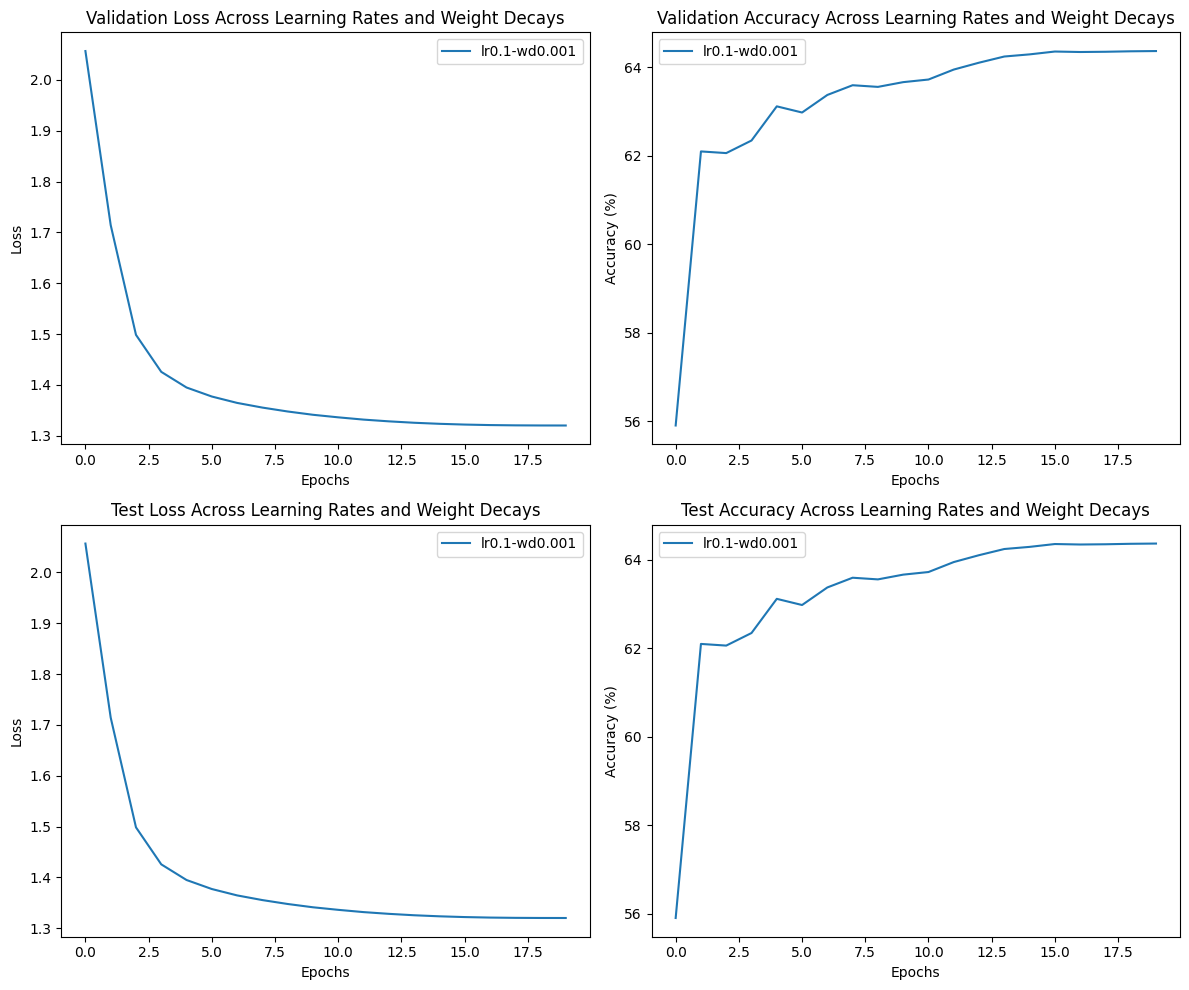

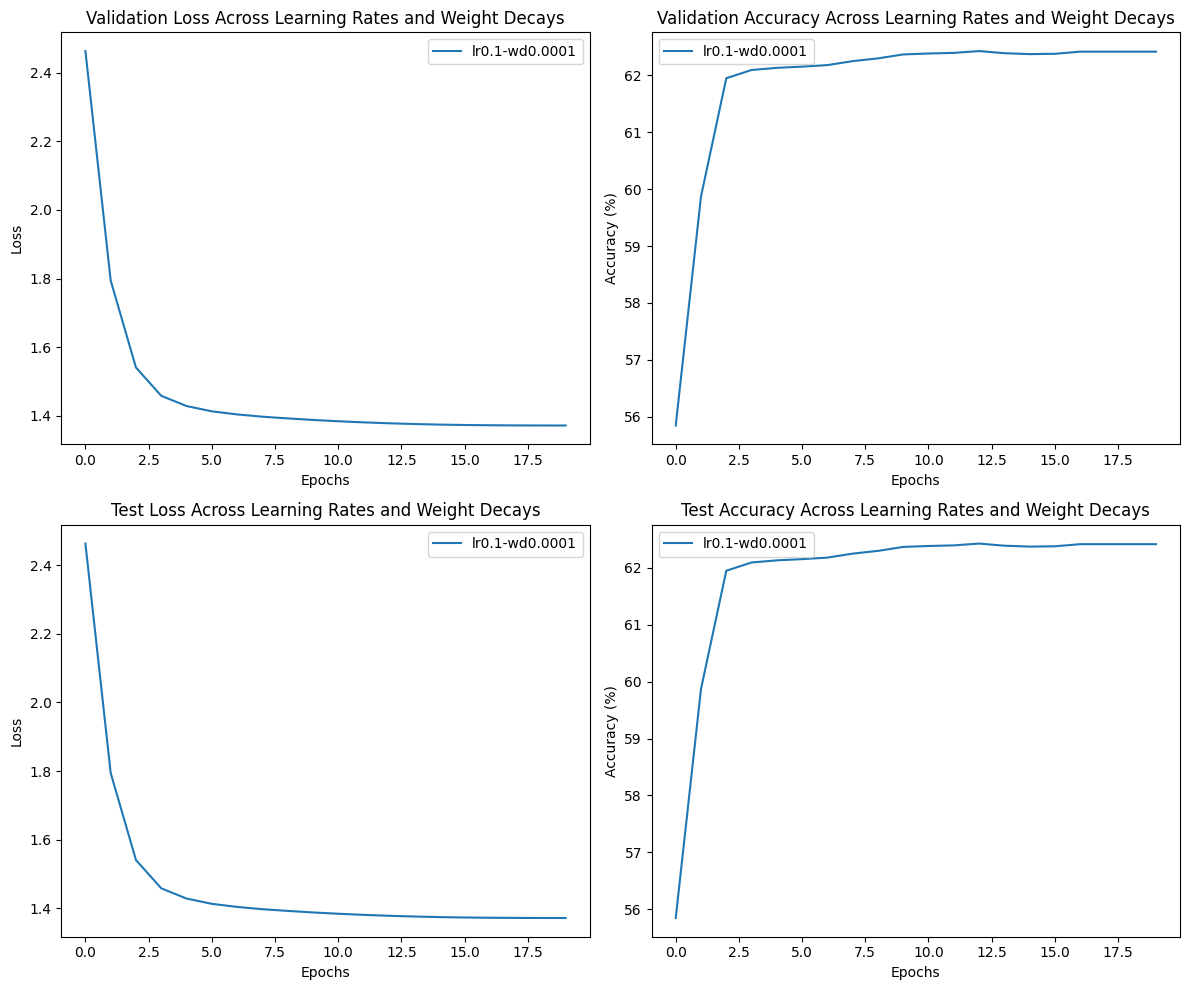

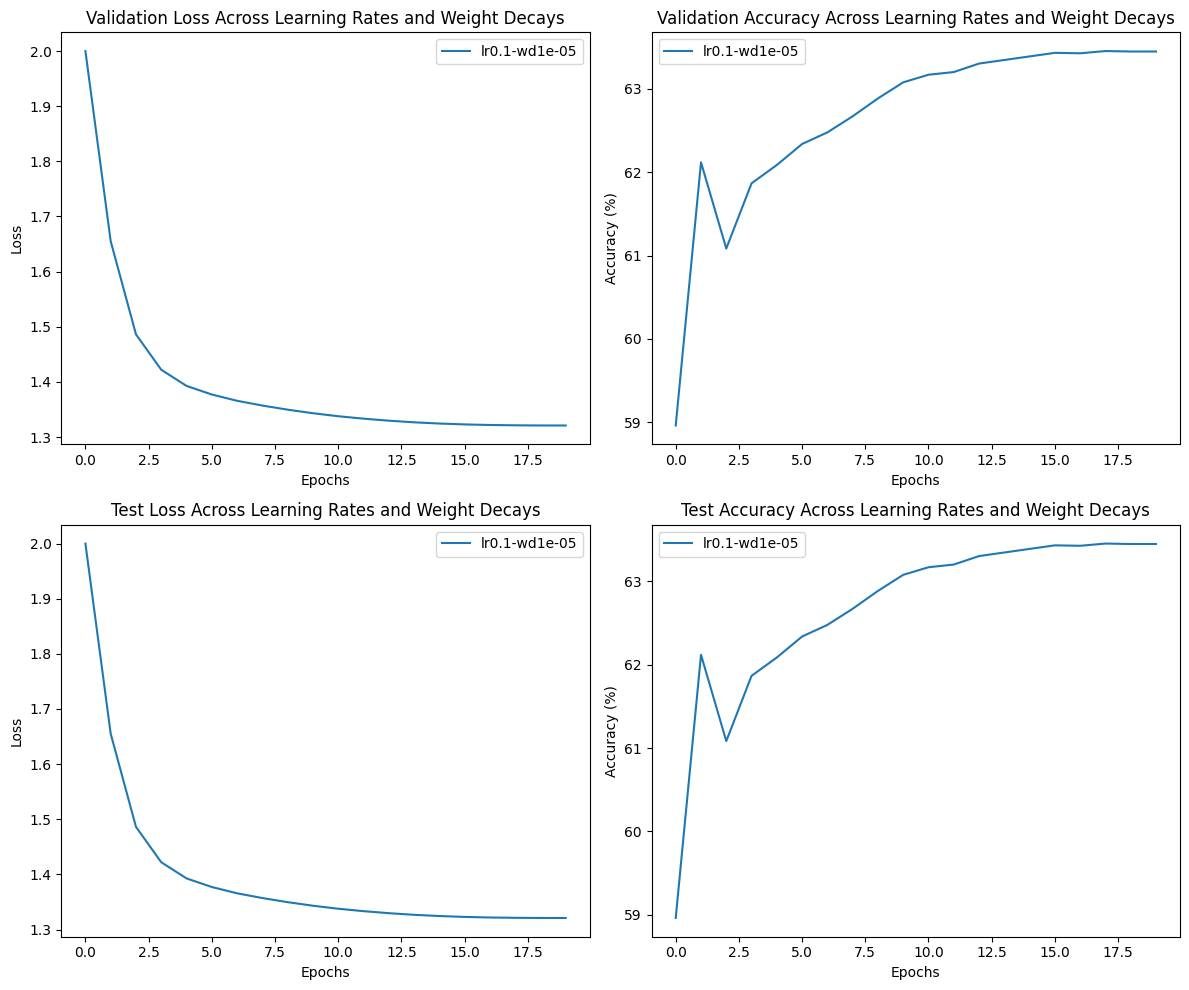

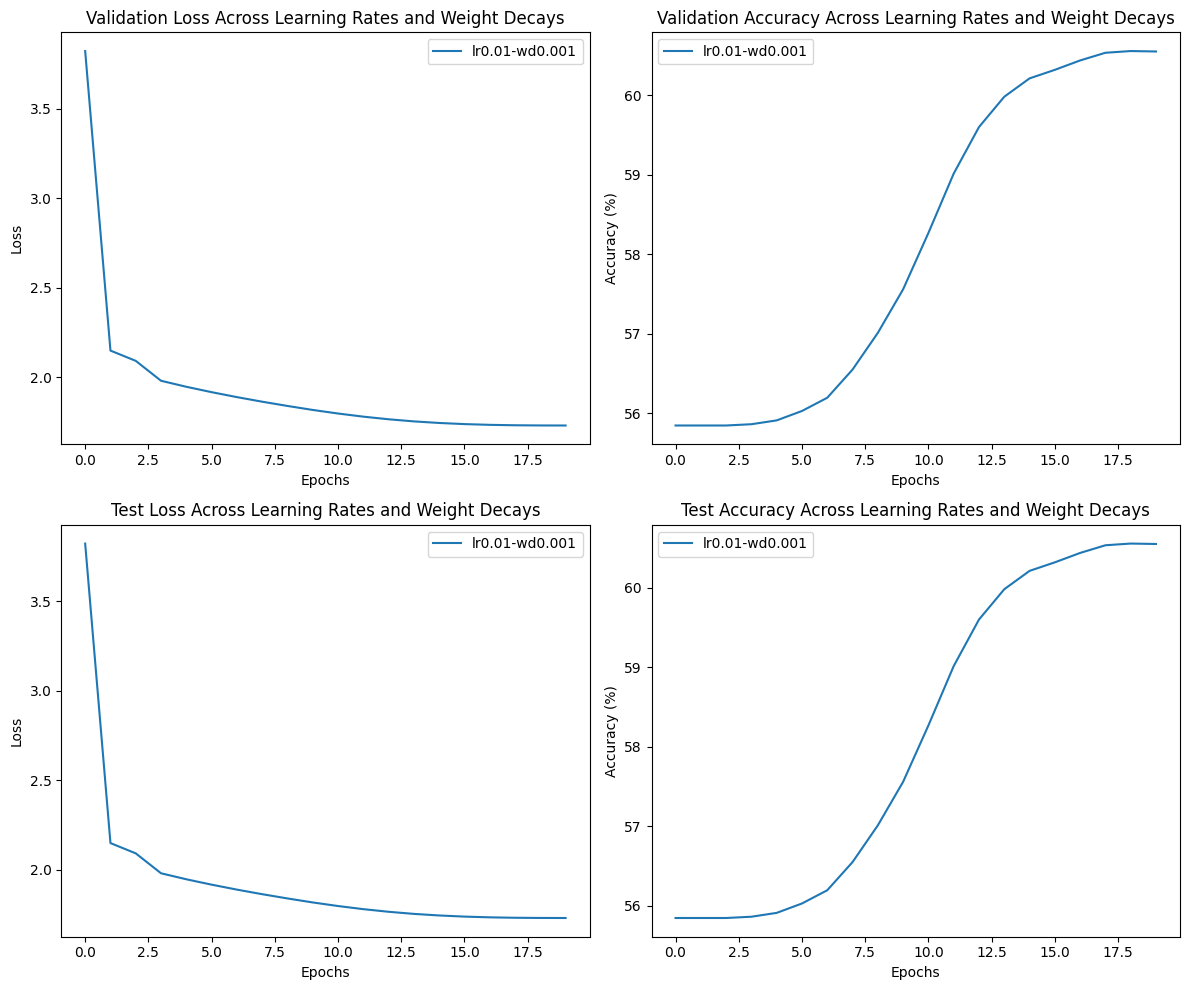

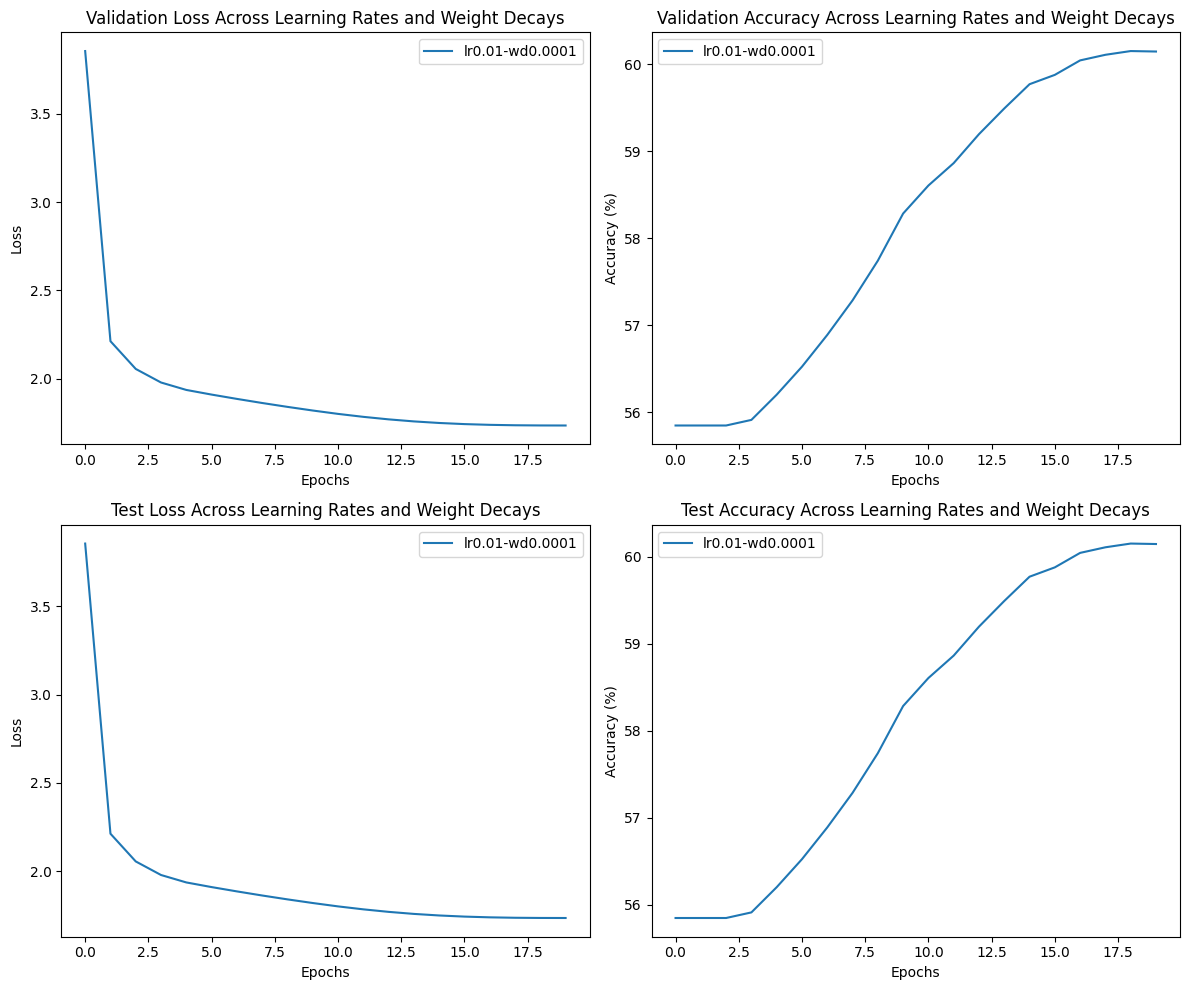

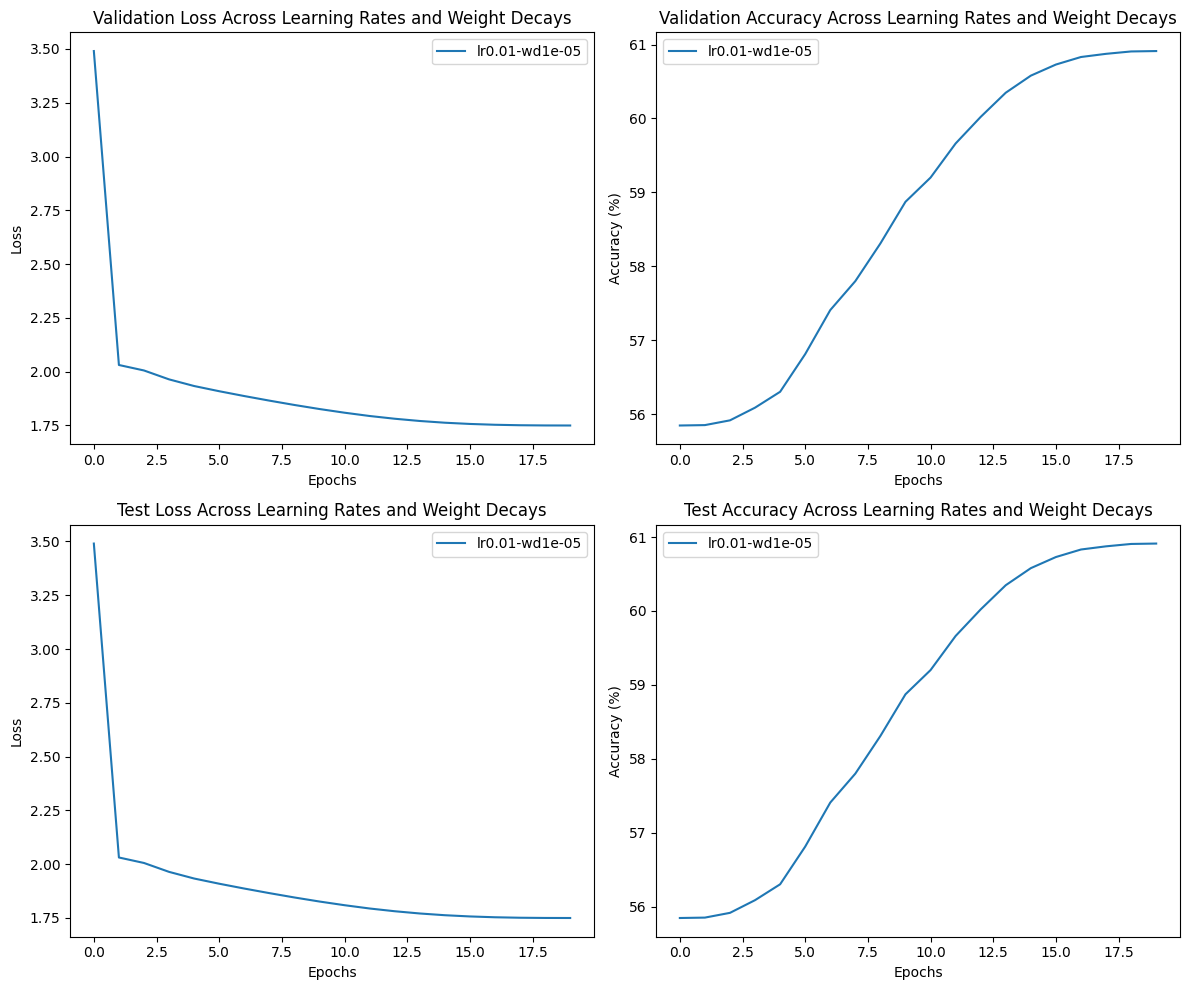

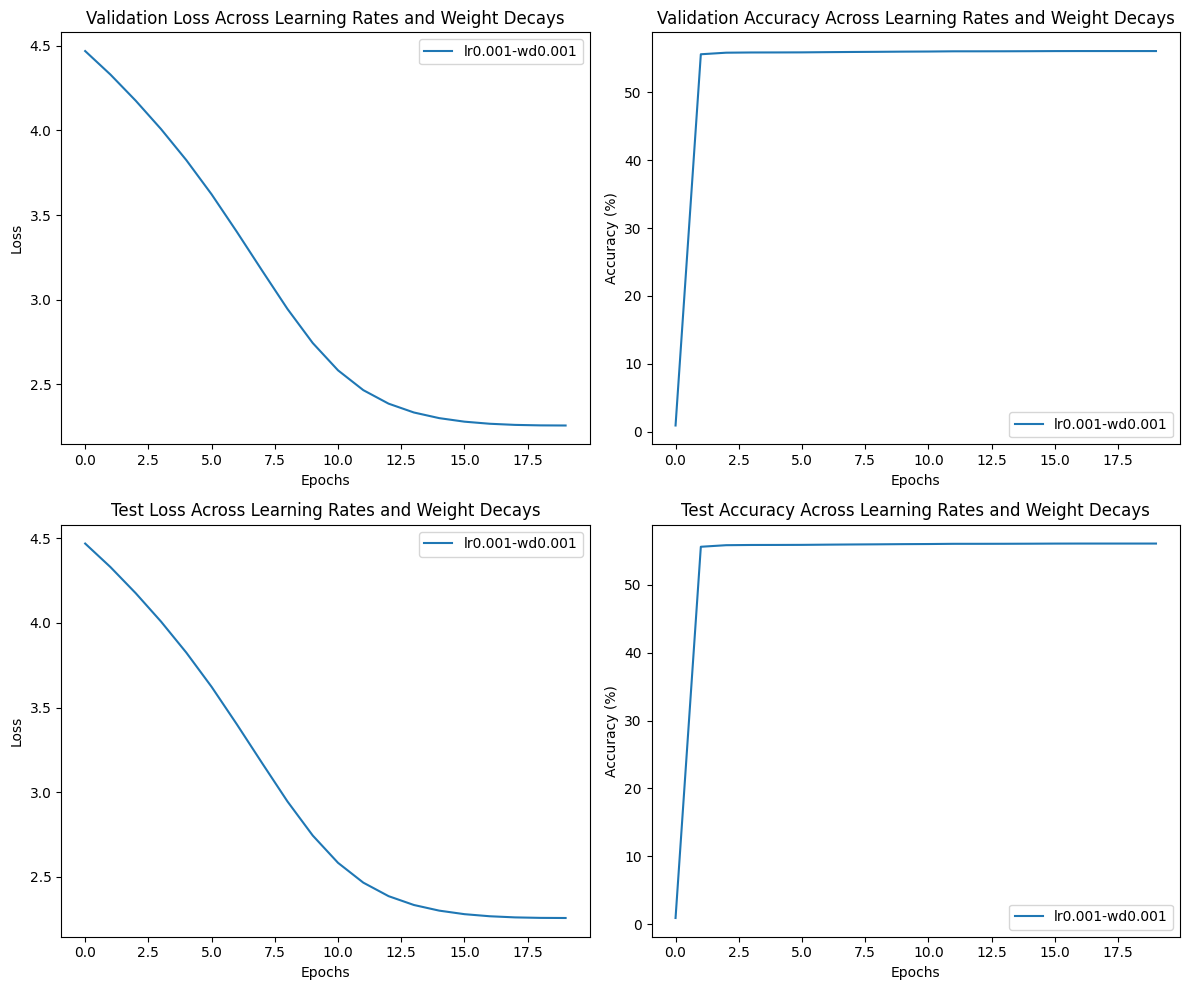

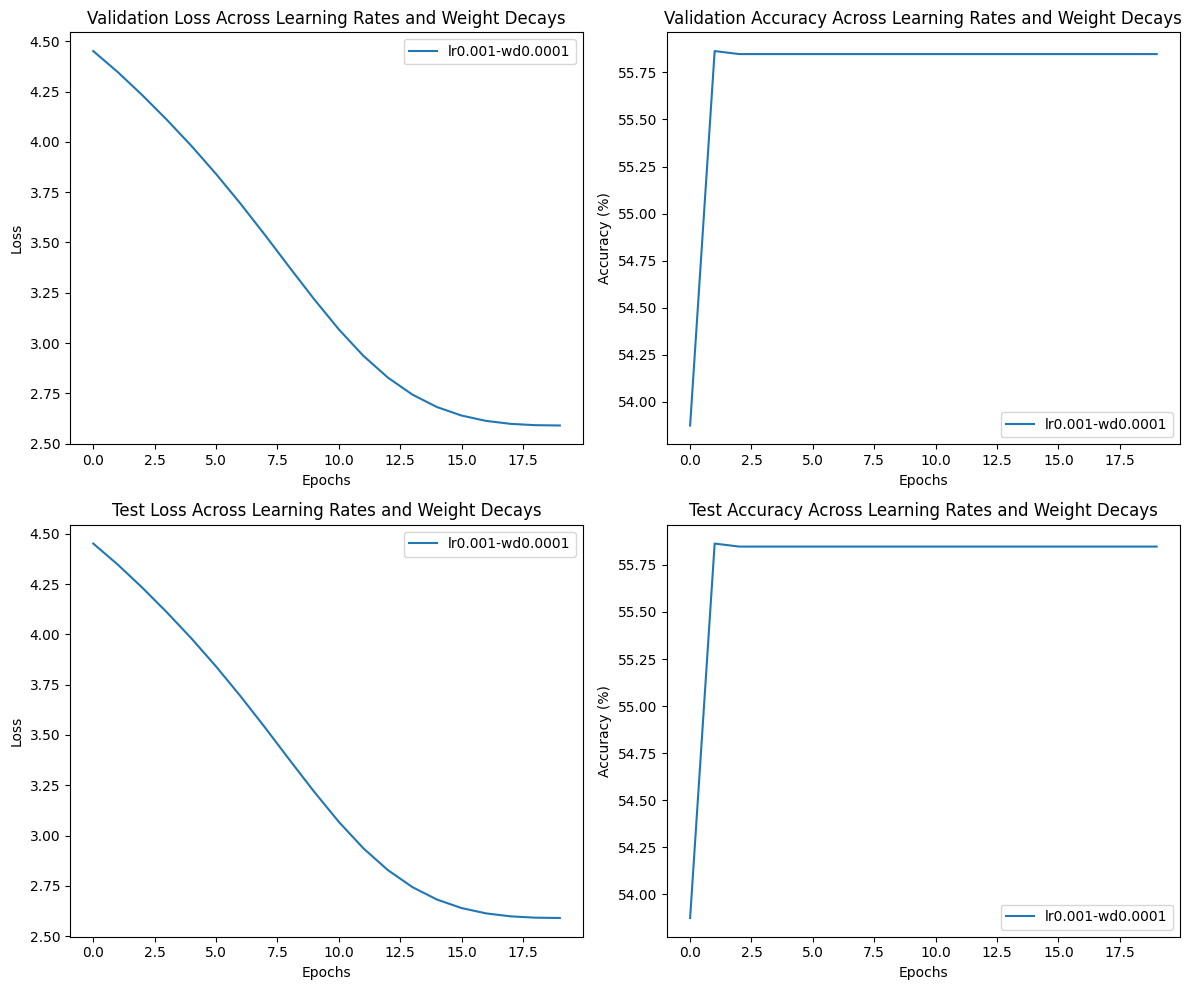

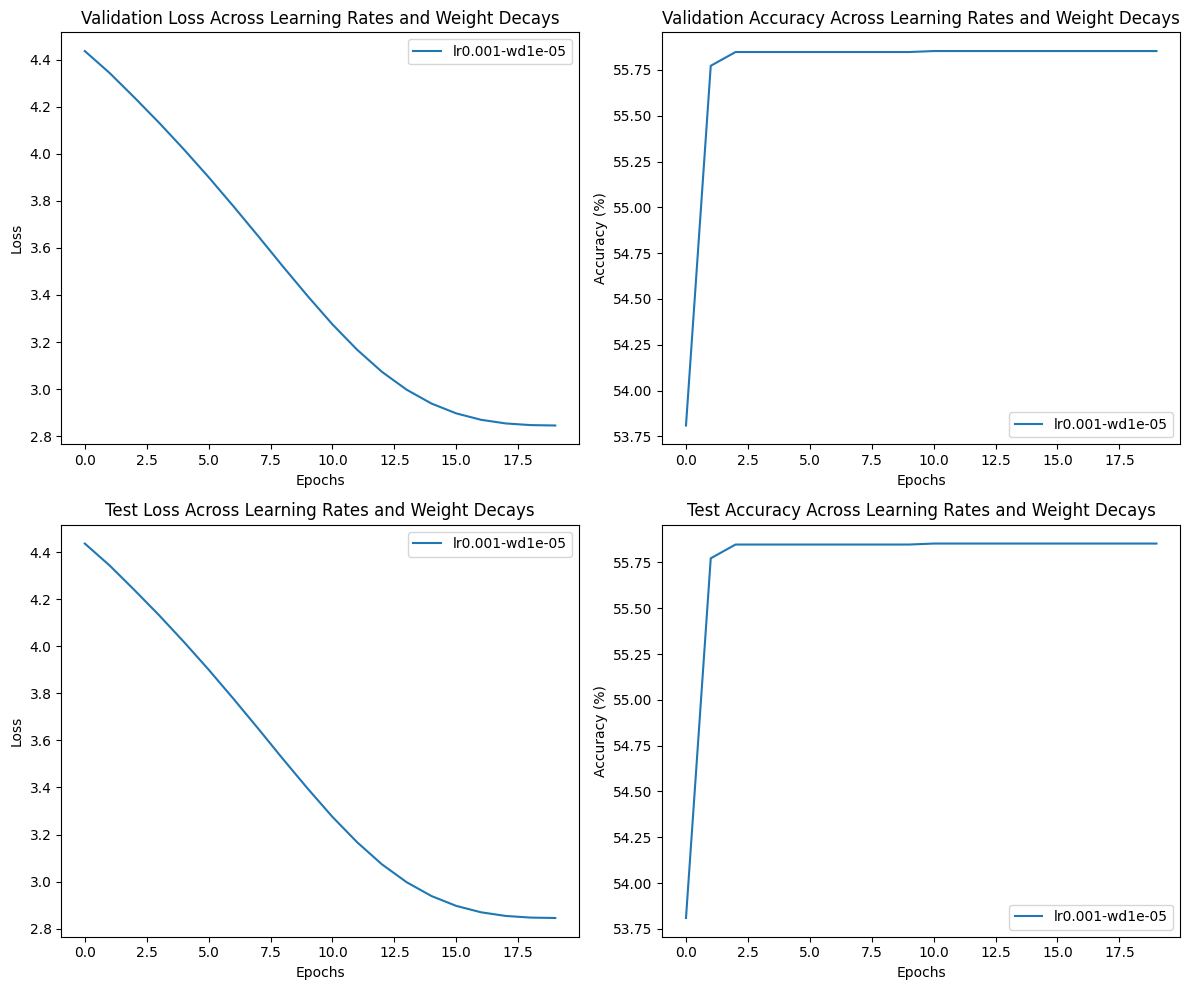

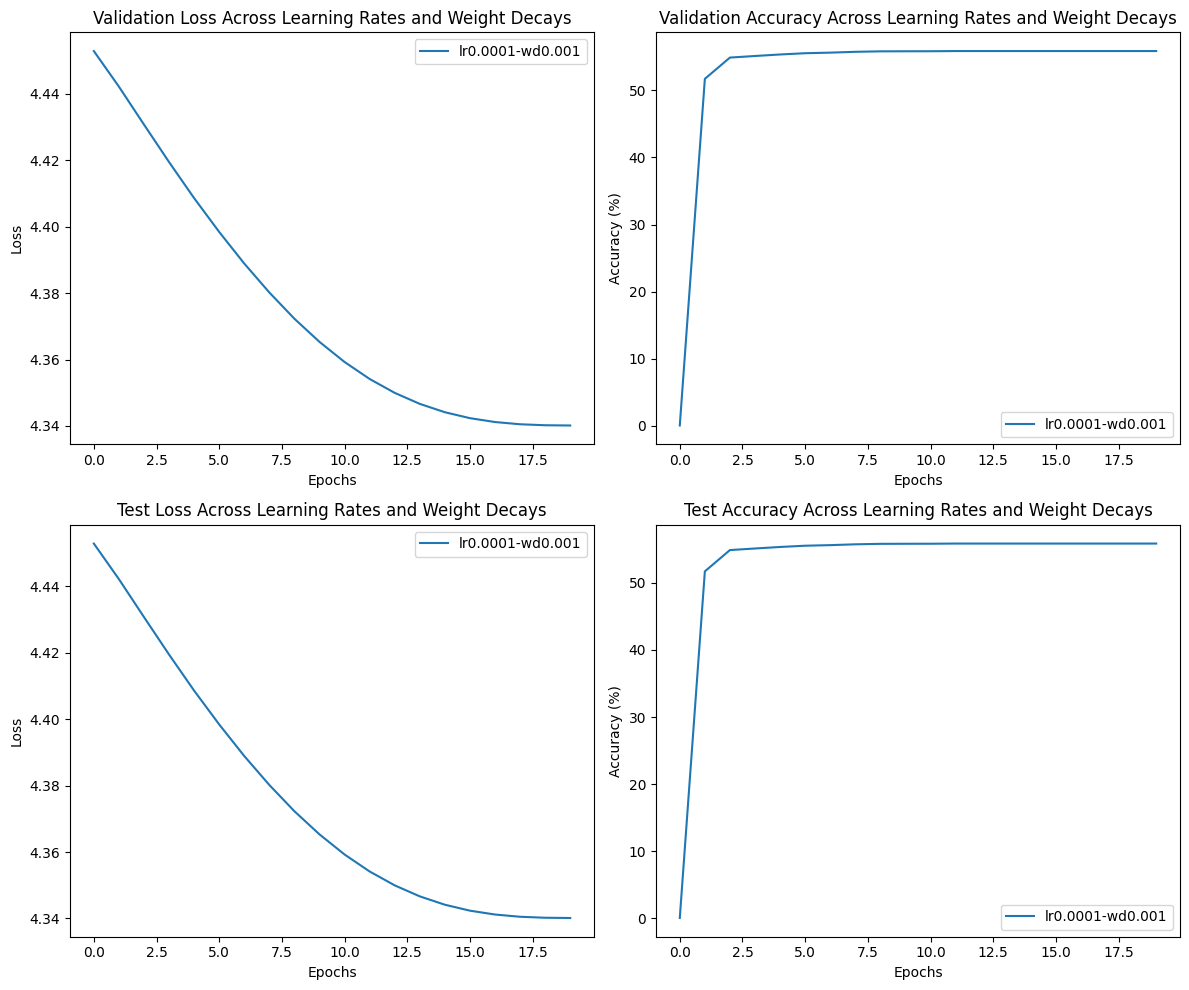

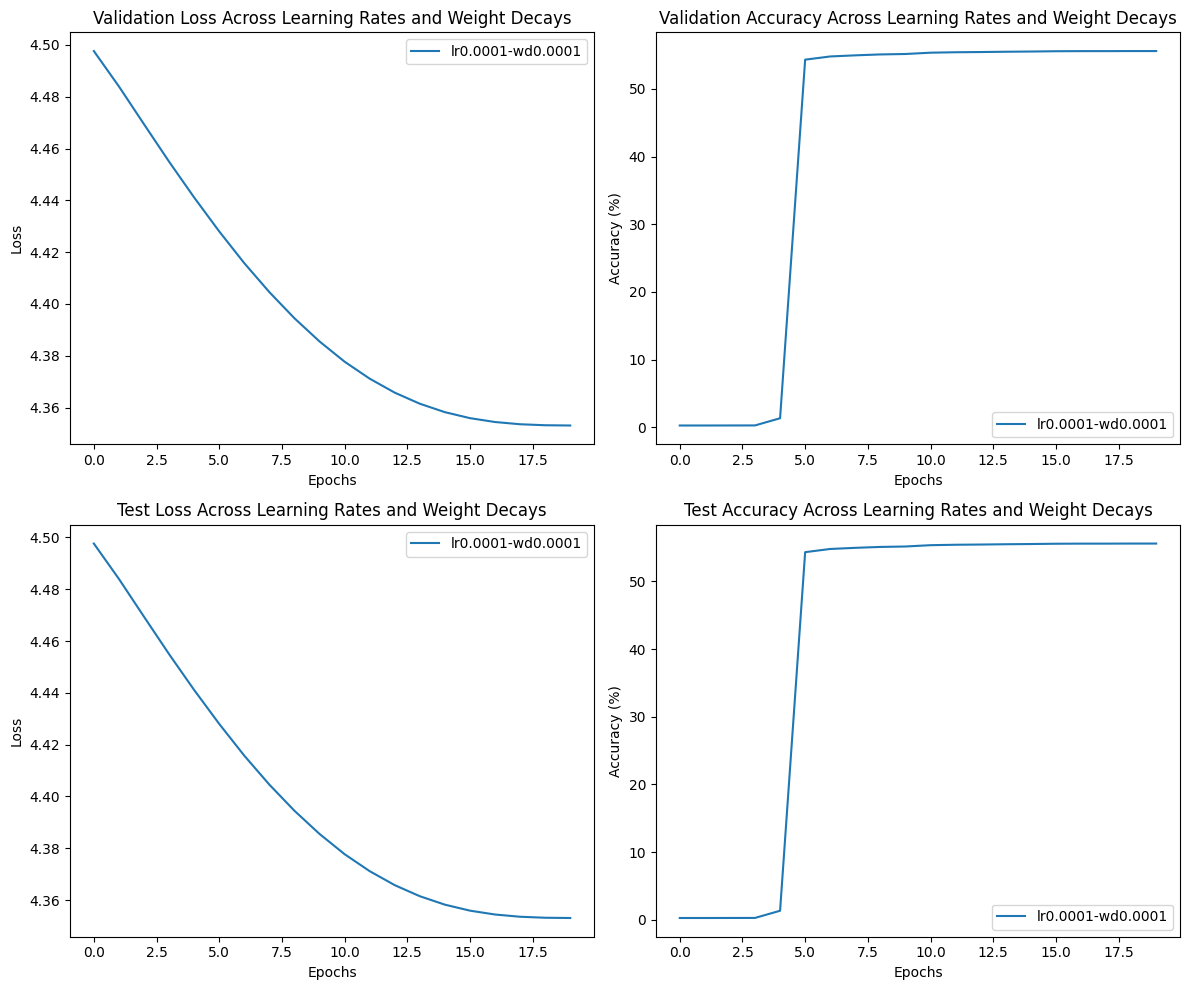

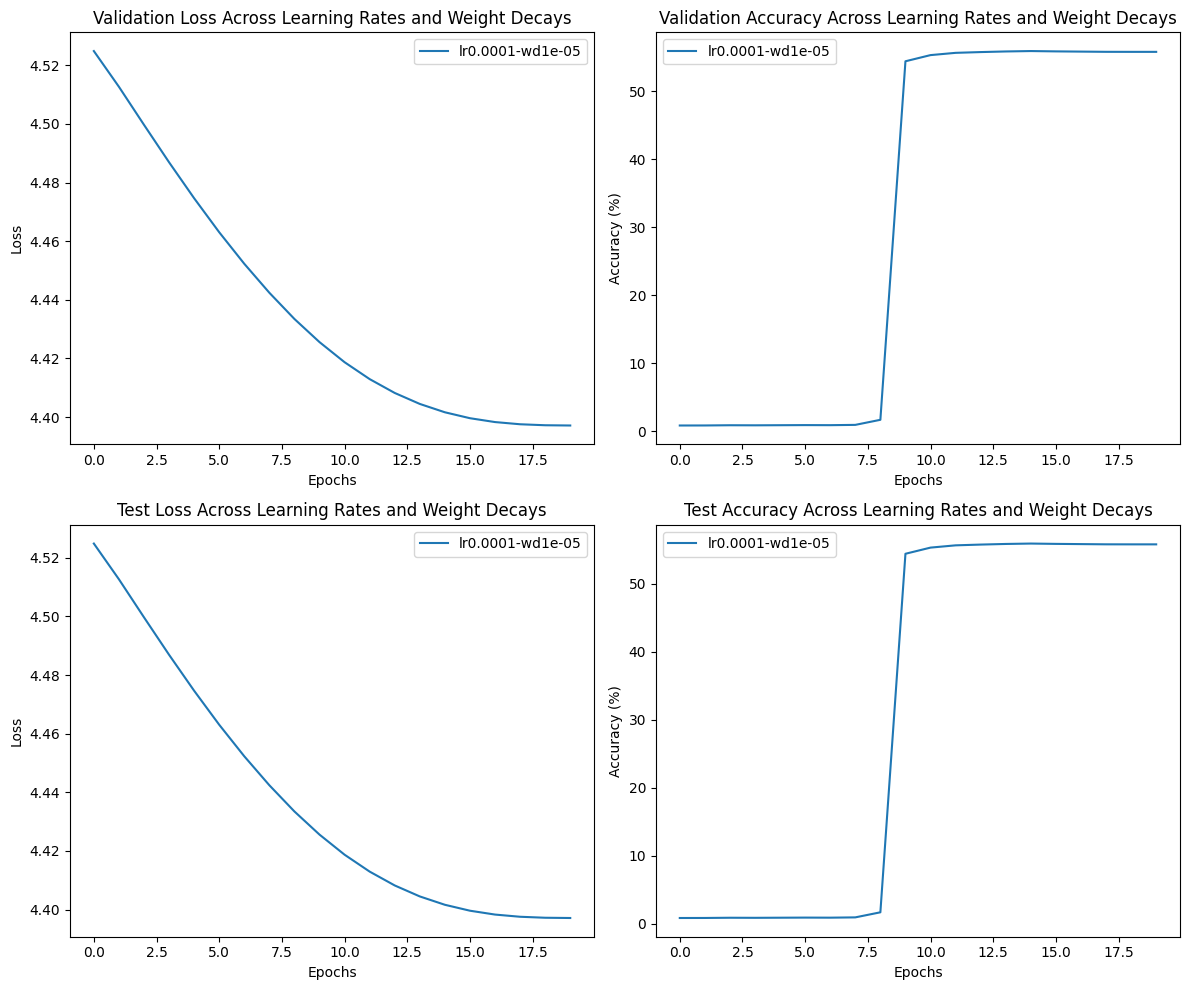

In [20]:
def main():
    # Dataset and training configurations
    data_path = "shakespeare.txt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    epochs = 20  # Number of epochs for centralized training -> # TODO search hyperparameters for different epochs from 20 to 200
    seq_length = 80  # Sequence length for LSTM inputs
    batch_size = 64 # batch size for centralized
    n_vocab = 90 # Character number in vobulary (ASCII)    
    # learning_rate = np.logspace(-3, 1, num=11) # Paper 2 give a range for learning rate's value from 10^(-3) to 10^1
    learning_rate = [1e-1, 1e-2, 1e-3, 1e-4]
    embedding_size = 8
    hidden_dim = 256
    train_split = 0.8 # In LEAF Dataset the common split used is 80/20
    momentum = 0.9 
    weight_decay = [1e-3, 1e-4, 1e-5]

    # Load data
    train_data, test_data = parse_shakespeare(data_path, train_split)

    # Centralized Dataset Preparation
    train_dataset = ShakespeareDataset(train_data, seq_length=seq_length, n_vocab=n_vocab)
    test_dataset = ShakespeareDataset(test_data, seq_length=seq_length, n_vocab=n_vocab)
    train_size = int(0.8 * len(train_dataset))  # 80% of data for training
    val_size = len(train_dataset) - train_size  # 20% of data for validation
    train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ====================
    # Start Centralized Training
    # ====================
    print("Starting centralized training...")

    # Saving best result
    best_result = {
        "hyperparameters": None,
        "val_accuracy": 0.0,
        "val_loss": float('inf'),
        "test_loss": float('inf'),
        "test_accuracy": 0.0
    }
    test_tot_losses = {}
    test_tot_accuracies = {}
    
    for lr in learning_rate:
        for wd in weight_decay:
            print(f"Learning Rate = {lr} and Weight Decay = {wd}")

            model = CharLSTM(n_vocab, embedding_size, hidden_dim, seq_length, num_layers=2)  # Initialize LSTM model
            criterion = nn.CrossEntropyLoss()  # Loss function
            optimizer = optim.SGD(model.parameters(), lr, momentum, 0, wd)  # Optimizer
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # Learning rate scheduler


            # Train and evaluate centralized model
            train_losses, train_accuracies, validation_losses, validation_accuracies, test_losses, test_accuracies = train_centralized(
                model, train_loader, test_loader, val_loader, criterion, optimizer, scheduler, epochs, device, lr, wd
            )
            test_tot_losses[f"Learning Rate = {lr} and Weight Decay = {wd}"] = test_losses
            test_tot_accuracies[f"Learning Rate = {lr} and Weight Decay = {wd}"] = test_accuracies

            if validation_losses[-1] < best_result["val_loss"]:
                best_result["hyperparameters"] = f"LR={lr} WD={wd}"
                best_result["val_accuracy"] = validation_accuracies[-1]
                best_result["val_loss"] = validation_losses[-1]
                best_result["test_loss"] = test_losses[-1]
                best_result["test_accuracy"] = test_accuracies[-1]
                print(f"Update best result -> Val Accuracy: {validation_accuracies[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

            plot_results_centralized(validation_losses, validation_accuracies, lr, wd)
            
    # Print best parameters found
    print(f"Best parameters:\n{best_result} ")

# Best parameters:
# {'hyperparameters': 'LR=0.1 WD=0.001', 'val_accuracy': 64.36695278969957, 'val_loss': 1.3201202750205994, 
# 'test_loss': 1.52342773111243, 'test_accuracy': 61.0266323024055} 

if __name__ == "__main__":
    main()
